# Initial Setup

In [3]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm.notebook import trange, tqdm
from random import random
import pandas as pd
import matplotlib
import numpy as np
import csv
import itertools
import pickle as pkl

import time
import datetime
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import mplfinance as mpl

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from IPython.display import Audio
sound_file = '../sound/done.mp3'
Audio(sound_file, autoplay=True)

import pmdarima as pm
from pmdarima.metrics import smape
from sklearn.metrics import mean_squared_error as mse

import prophet

from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *
from Pmdarima_Model import Pmdarima_Model


# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

## Get NYSE calendar

In [4]:
NYSE = mcal.get_calendar('NYSE')

## Set up Frequency Variables

### Custom Business Hour

In [5]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [6]:
# CBD = pd.offsets.CustomBusinessDay(calendar=CustomUSHolidayCalendar())
CBD = NYSE.holidays()
CBD

<CustomBusinessDay>

# YFinance

## Setup / Gather Data

In [7]:
symbol = 'SPY'
# YF_COLUMNS = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

In [8]:
years = [3, 5, 10, 30]
get_yf_time_series(yf, years, symbol, freq=CBD)

## Load Data from File

### 3Y

In [9]:
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_df_all = load_yf_time_series(yf, 30, symbol, freq=CBD)

## Data Preparation

### EDA

In [13]:
spy_df_all

open        high         low       close   adj_close  \
date                                                                     
1993-01-29   43.968750   43.968750   43.750000   43.937500   25.884184   
1993-02-01   43.968750   44.250000   43.968750   44.250000   26.068277   
1993-02-02   44.218750   44.375000   44.125000   44.343750   26.123499   
1993-02-03   44.406250   44.843750   44.375000   44.812500   26.399649   
1993-02-04   44.968750   45.093750   44.468750   45.000000   26.510111   
...                ...         ...         ...         ...         ...   
2021-05-03  419.429993  419.839996  417.670013  418.200012  418.200012   
2021-05-04  416.070007  416.600006  411.670013  415.619995  415.619995   
2021-05-05  417.380005  417.630005  415.149994  415.750000  415.750000   
2021-05-06  415.829987  419.209991  413.679993  419.070007  419.070007   
2021-05-07  419.890015  422.820007  419.160004  422.119995  422.119995   

               volume  
date                   
1993-01-29    1003200  
1993-02-01     480500  
1993-02-02     201300  
1993-02-03     529400  
1993-02-04     531500  
...               ...  
2021-05-03   68128300  
2021-05-04  101591200  
2021-05-05   39960700  
2021-05-06   74321400  
2021-05-07   67680100  

[7120 rows x 6 columns]

In [14]:
spy_df_3Y = spy_df_3Y.asfreq(CBD)
spy_df_5Y = spy_df_5Y.asfreq(CBD)
spy_df_10Y = spy_df_10Y.asfreq(CBD)
spy_df_all = spy_df_all.asfreq(CBD)

In [15]:
spy_df_10Y.isna().sum(), spy_df_10Y.isna().sum(), spy_df_10Y.isna().sum()

(open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64,
 open         0
 high         0
 low          0
 close        0
 adj_close    0
 volume       0
 dtype: int64)

### Remove today's incomplete data (if needed)

In [16]:
# spy_df_3Y.drop(spy_df_3Y.tail(1).index, inplace=True)
# spy_df_5Y.drop(spy_df_5Y.tail(1).index, inplace=True)
# spy_df_10Y.drop(spy_df_10Y.tail(1).index, inplace=True)

### Impute Missing Values

In [17]:
# spy_df_3Y = spy_df_3Y.interpolate()
# spy_df_5Y = spy_df_5Y.interpolate()
# spy_df_10Y = spy_df_10Y.interpolate()

### Create Time Series for `Close`, `Volume`

In [18]:
df_3Y_close = spy_df_3Y.close
df_3Y_vol = spy_df_3Y.volume
df_5Y_close = spy_df_5Y.close
df_5Y_vol = spy_df_5Y.volume
df_10Y_close = spy_df_10Y.close
df_10Y_vol = spy_df_10Y.volume
df_all_close = spy_df_all.close
df_all_vol = spy_df_all.volume

In [19]:
df_all_close

date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
Freq: C, Name: close, Length: 7120, dtype: float64

In [20]:
df_all_close.isna().sum()

0

In [21]:
df_10Y_close, df_10Y_vol

(date
 2011-05-02    136.220001
 2011-05-03    135.729996
 2011-05-04    134.830002
 2011-05-05    133.610001
 2011-05-06    134.199997
                  ...    
 2021-05-03    418.200012
 2021-05-04    415.619995
 2021-05-05    415.750000
 2021-05-06    419.070007
 2021-05-07    422.119995
 Freq: C, Name: close, Length: 2522, dtype: float64,
 date
 2011-05-02    126278700
 2011-05-03    138375000
 2011-05-04    182678500
 2011-05-05    226900000
 2011-05-06    222787200
                 ...    
 2021-05-03     68128300
 2021-05-04    101591200
 2021-05-05     39960700
 2021-05-06     74321400
 2021-05-07     67680100
 Freq: C, Name: volume, Length: 2522, dtype: int64)

### Create Time Series for `Open`, `High`, `Low`, `adj_close`

In [22]:
df_3Y_open = spy_df_3Y.open
df_3Y_high = spy_df_3Y.high
df_3Y_low = spy_df_3Y.open
df_3Y_a_close = spy_df_3Y.adj_close
df_5Y_open = spy_df_5Y.open
df_5Y_high = spy_df_5Y.high
df_5Y_low = spy_df_5Y.open
df_5Y_a_close = spy_df_5Y.adj_close
df_10Y_open = spy_df_10Y.open
df_10Y_high = spy_df_10Y.high
df_10Y_low = spy_df_10Y.open
df_10Y_a_close = spy_df_10Y.adj_close
df_all_open = spy_df_all.open
df_all_high = spy_df_all.high
df_all_low = spy_df_all.open
df_all_a_close = spy_df_all.adj_close

### Create 2D Volume Time Series

In [23]:
df_3Y_close.shape

(761,)

In [24]:
vol_3Y_df = pd.DataFrame(df_3Y_vol).reset_index()
vol_5Y_df = pd.DataFrame(df_5Y_vol).reset_index()
vol_10Y_df = pd.DataFrame(df_10Y_vol).reset_index()

### Create Future Dates

In [25]:
# no longer needed due to custom function

today = pd.Timestamp.today()
new_dates = pd.date_range(start=today, periods=5, freq=CBD)

index_3Y_fc = range(df_3Y_close.size, df_3Y_close.size + 5)
index_5Y_fc = range(df_5Y_close.size, df_5Y_close.size + 5)
index_10Y_fc = range(df_10Y_close.size, df_10Y_close.size + 5)

new_dates_3Y_df = pd.DataFrame(new_dates, index=index_3Y_fc, columns=['date'])
new_dates_5Y_df = pd.DataFrame(new_dates, index=index_5Y_fc, columns=['date'])
new_dates_10Y_df = pd.DataFrame(new_dates, index=index_10Y_fc, columns=['date'])

## Plot PACF

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



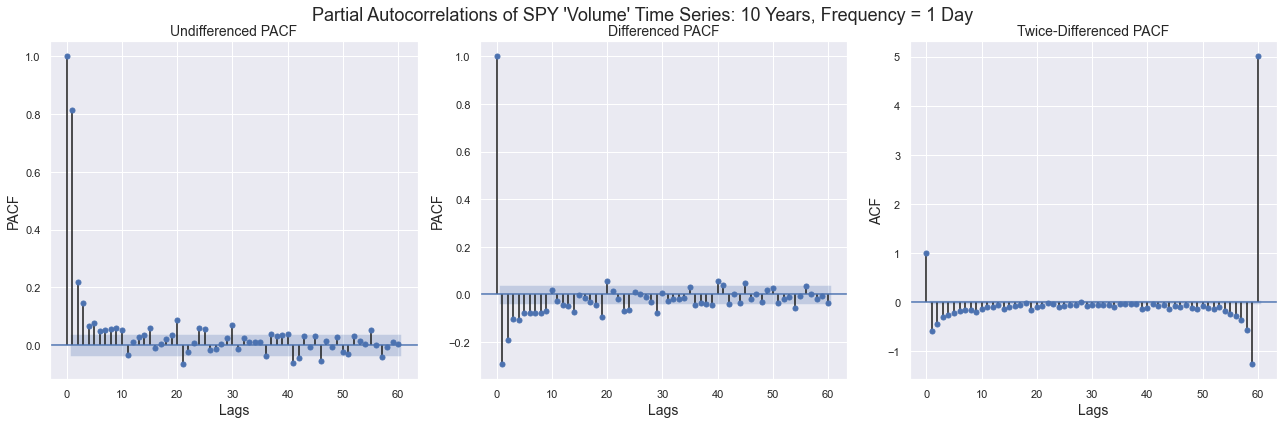

In [255]:
plot_pacf_with_diff(df_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', lags=60)

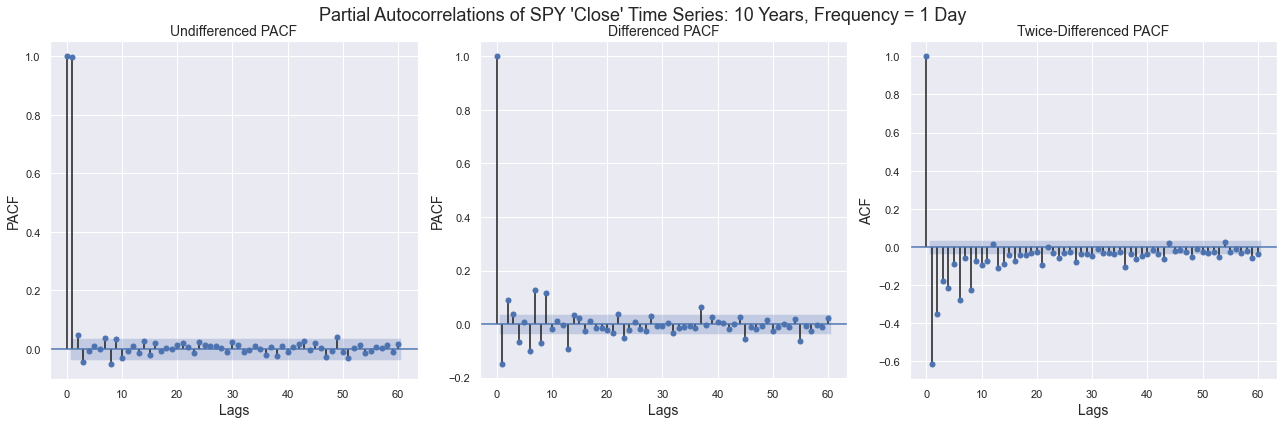

In [257]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', lags=60)

## Plot ACF

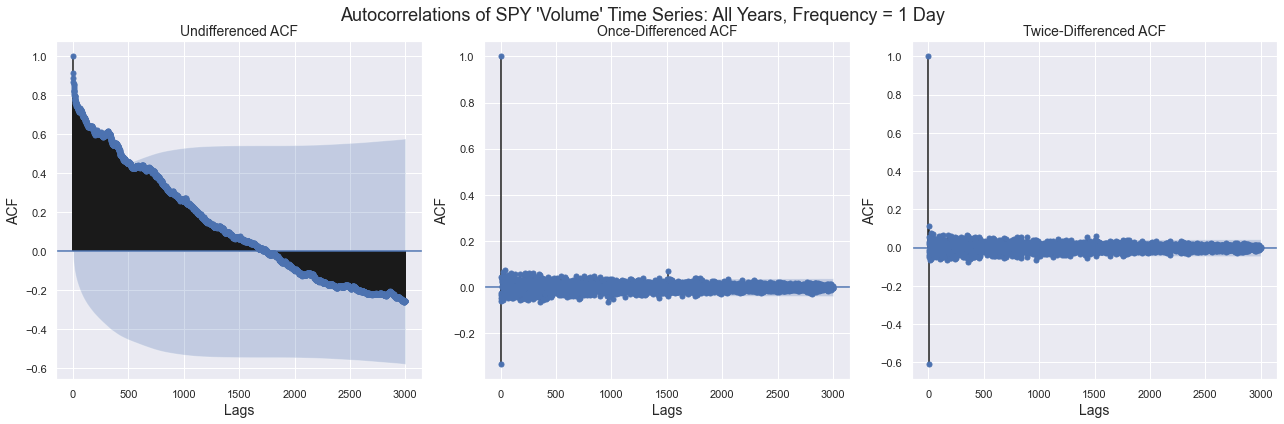

In [29]:
plot_acf_with_diff(df_all_vol, 'SPY \'Volume\'', 'All', 'years', '1 Day', lags=3000)

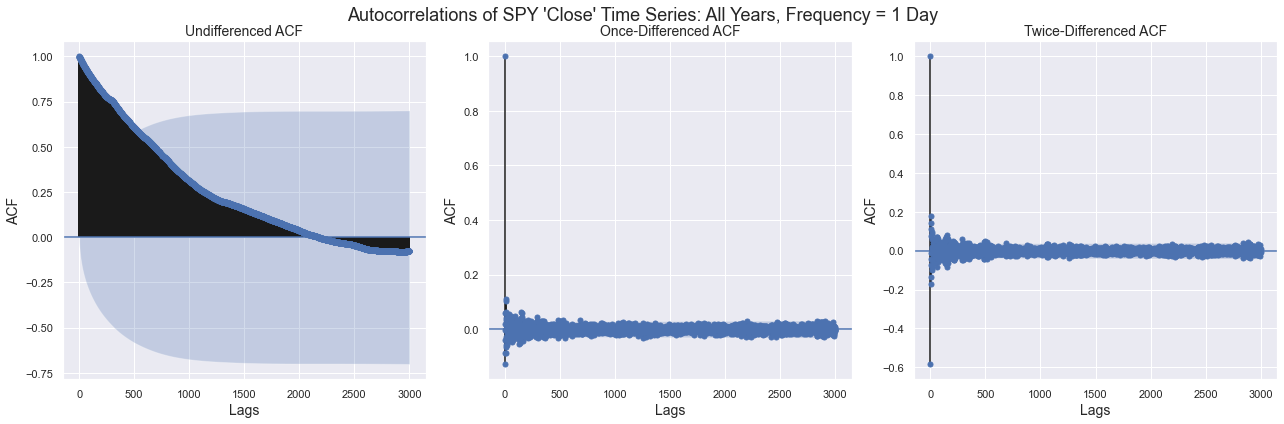

In [30]:
plot_acf_with_diff(df_all_close, 'SPY \'Close\'', 'All', 'years', '1 Day', lags=3000)

## Plot Seasonal Decomposition

### 3 Years, Freq = Custom Business Day, Yearly Seasonality

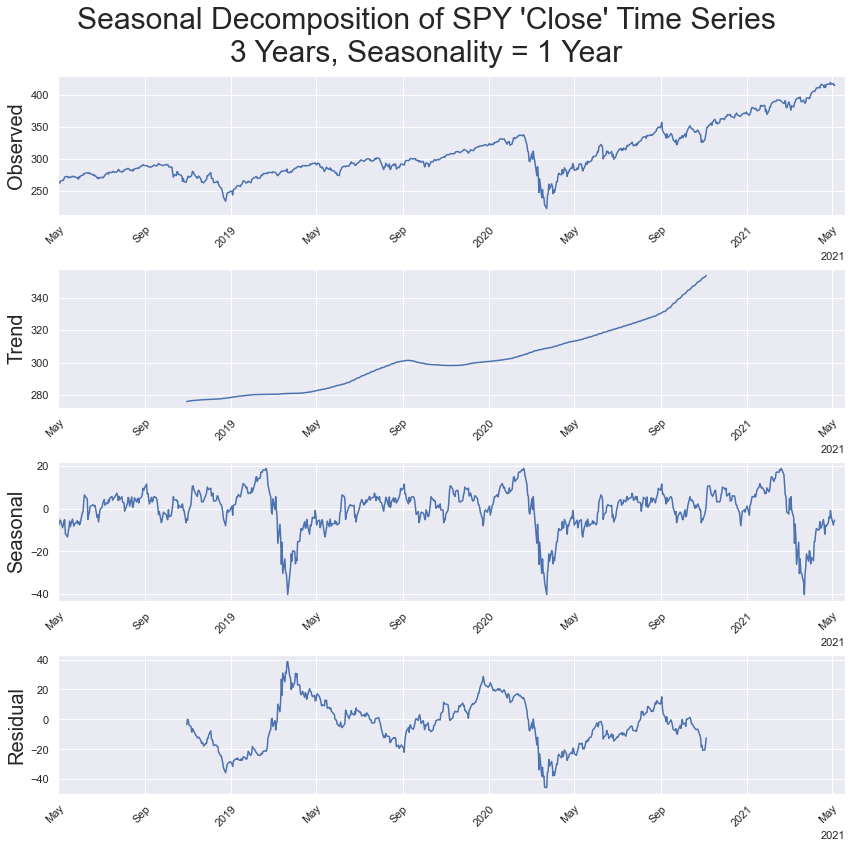

In [30]:
plot_seasonal_decomposition(df_3Y_close, 'SPY \'Close\'', 3, 'years', '1 Day', 261)

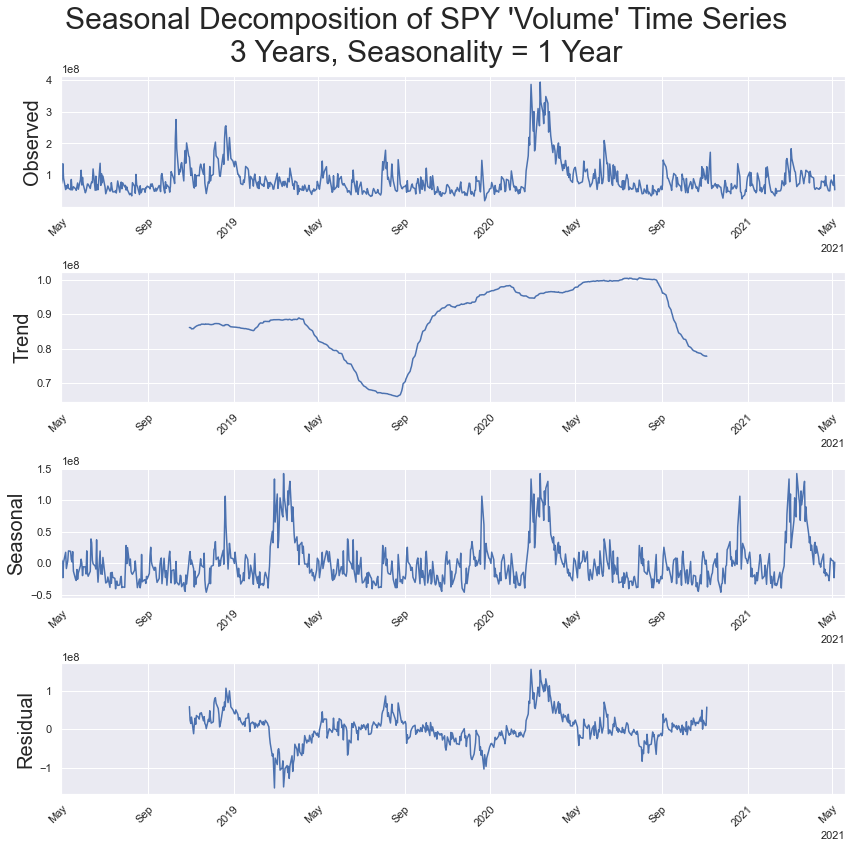

In [266]:
plot_seasonal_decomposition(df_3Y_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', 261)

### 5 Years, Freq = Custom Business Day, Yearly Seasonality

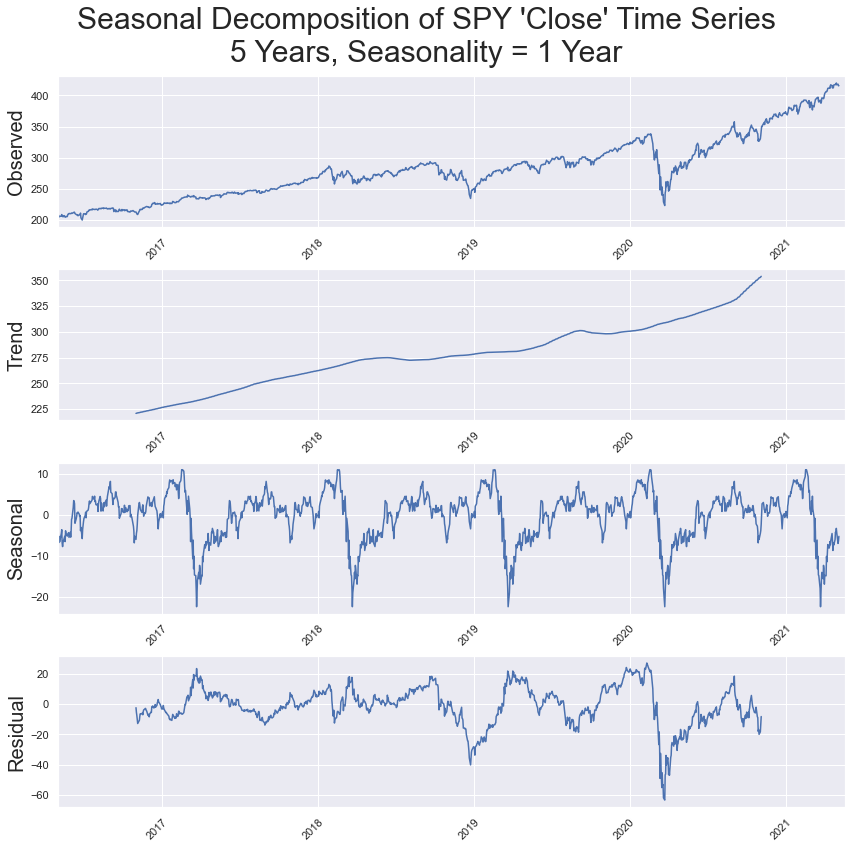

In [32]:
plot_seasonal_decomposition(df_5Y_close, 'SPY \'Close\'', 5, 'years', '1 Day', 261)

### 10 Years, Freq = Custom Business Day, Yearly Seasonality

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


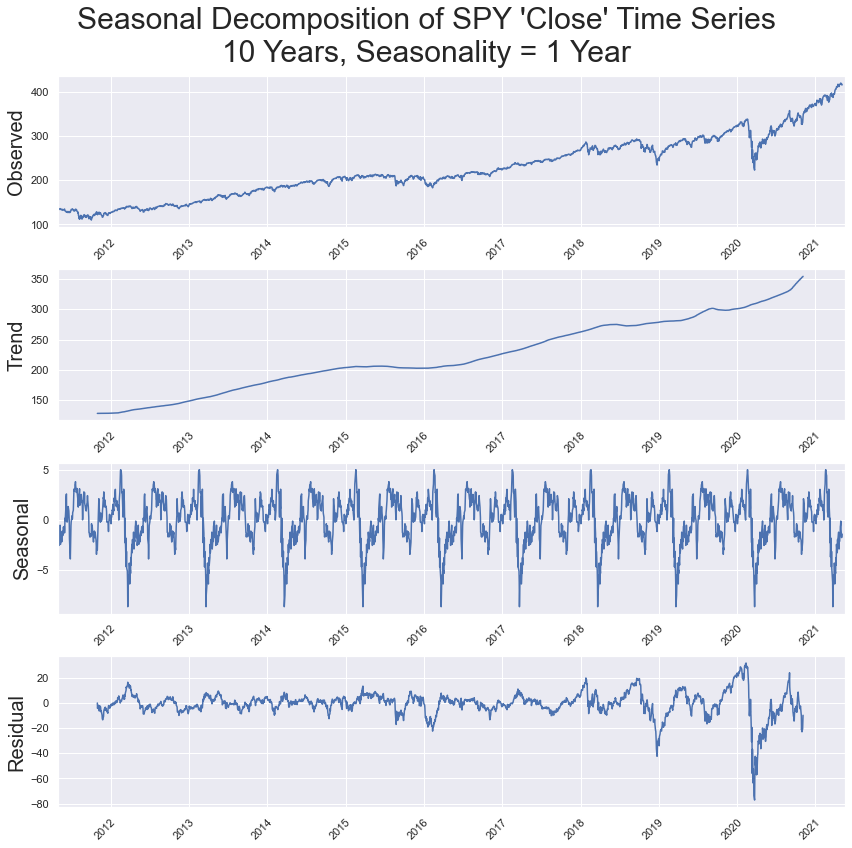

In [259]:
plot_seasonal_decomposition(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', 261)

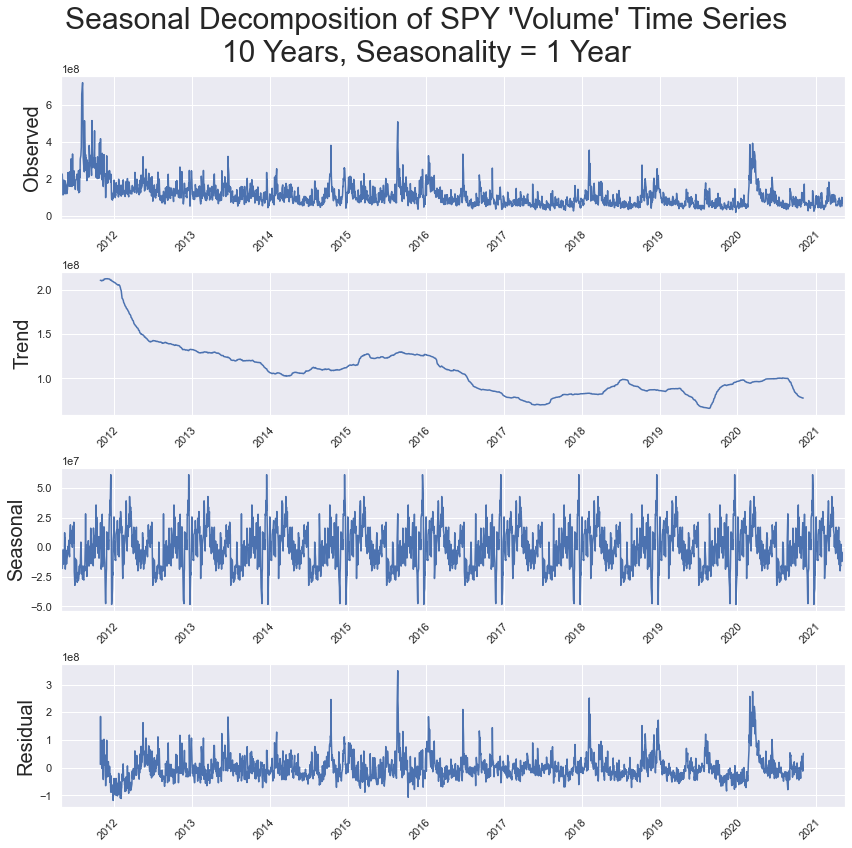

In [265]:
plot_seasonal_decomposition(df_10Y_vol, 'SPY \'Volume\'', 10, 'years', '1 Day', 261)

# Modeling with Close, Volume

## Last 3 Years, 1 Day

### Using Custom Class `Pmdarima_Model`

In [260]:
df_3Y_close.min()

222.9499969482422

#### Close

In [58]:
pam_3Y_close = Pmdarima_Model(df_3Y_close, 'SPY \'Close\'', order=(0,0,0),
               n=3, periods='years', freq='1 Day', f_seas=252, fit_seas=False, #with_intercept=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1, trend='t', k=4,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3440.897, Time=1.81 sec
First viable model found (3440.897)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3486.669, Time=1.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3451.308, Time=2.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3460.270, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3484.923, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3440.157, Time=1.43 sec
New best model found (3440.157 < 3440.897)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3439.208, Time=0.77 sec
New best model found (3439.208 < 3440.157)
 AR

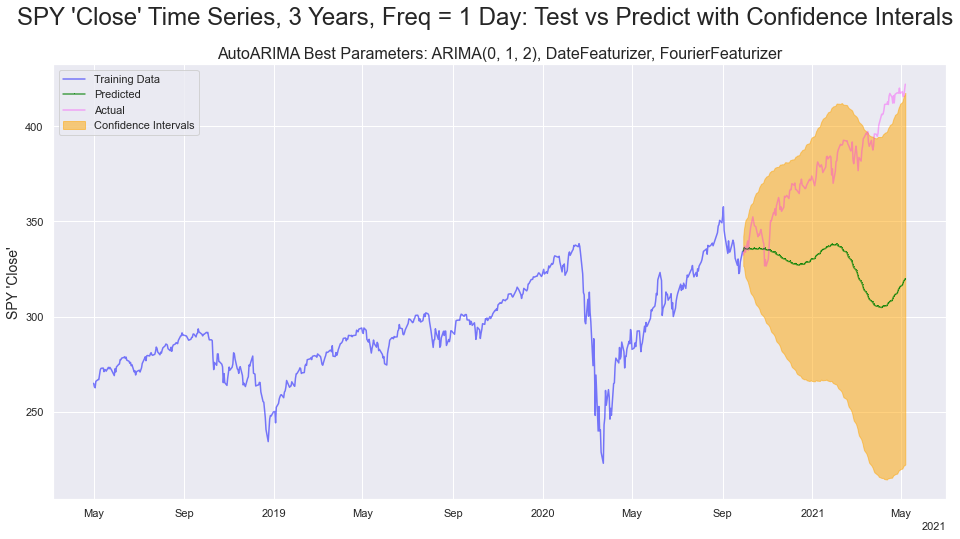

In [18]:
pam_3Y_auto_pipe = pam_3Y_close.run_auto_pipeline(verbose=1, visualize=True)

In [19]:
pam_3Y_close.AA_best_mod_params_df

ARIMA_Order Trend Intercept  Date  Fourier  Fourier_m  Fourier_k  \
Model                                                                    
0       (0, 1, 2)     c     False  True     True        252          4   

       BoxCox    Log  Scored   AIC  RMSE RMSE% SMAPE  
Model                                                 
0       False  False   False  None  None  None  None

ARIMA(0, 1, 2), DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 4264.826
Test RMSE: 3.607
This is 1.233% of the avg observed value.
Test SMAPE: 0.743%

Adding a new score.
Model not found.


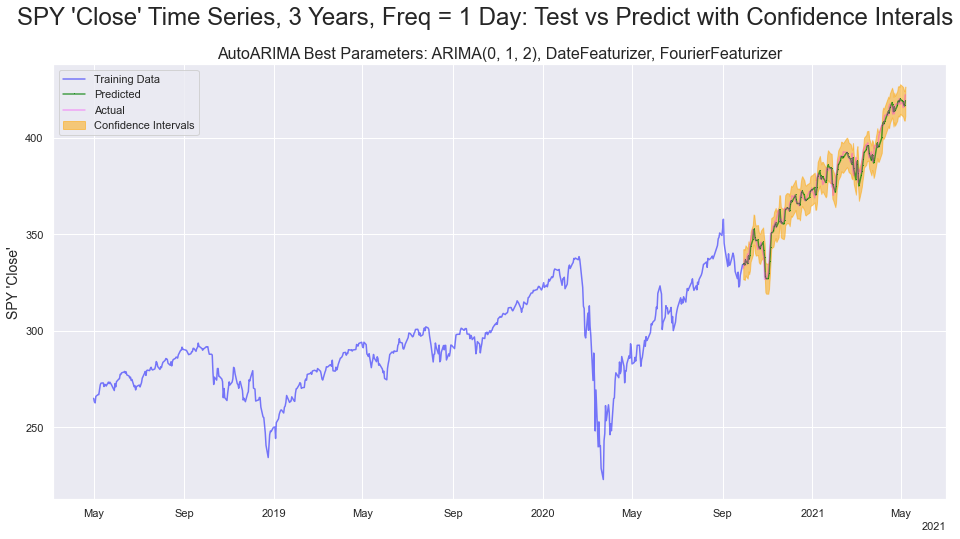

In [20]:
AIC, RMSE, RMSE_pc, SMAPE = pam_3Y_close.run_stepwise_CV(func='AA', dynamic=False, verbose=1, visualize=True)

In [123]:
Audio(sound_file, autoplay=True)

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


##### GridSearch

In [506]:
pam_3Y_best, scores = pam_3Y_close.run_gridsearch_CV(min_order=10, max_order=10, min_d=1, max_d=1, min_p=0, max_p=10, min_q=0, max_q=10,
                                    t_list=['t'], with_intercept=True, f_m=252, k=2,
                                    fourier=False, box=False, log=False, debug=True, verbose=1, parallel=False)

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 1, 10)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. object object 
Added a model to test grid.
ARIMA Order(1, 1, 9)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. object object 
Added a model to test grid.
ARIMA Order(2, 1, 8)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. object object 
Added a model to test grid.
ARIMA Order(3, 1, 7)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. object object 
Added a model to test grid.
ARIMA Order(4, 1, 6)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Mode

________________________________________________________________________

Running step-wise cross-validation on model 1 of 8... 
ARIMA Order(0, 1, 10)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 10), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4211.303 | RMSE: 3.584 | RMSE%=1.225% | SMAPE 0.754%
Model[ARIMA Order(0, 1, 10)['t'], Intercept, DateFeaturizer]: AIC=4211.303 | RMSE=3.584 | RMSE_pc=1.225% | SMAPE=0.754%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 899
Adding scores to model, updating line 899. ________________________________________________________________________

Running step-wise cross-validation on model 2 of 8... 
ARIMA Order(1, 1, 9)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 9), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 4210.000 | RMSE: 3.571 | RMSE%=1.221% | SMAPE 0.753%
Model[ARIMA Order(1, 1, 9)['t'], Intercept, DateFeaturizer]: AIC=4210.000 | RMSE=3.571 | RMSE_pc=1.221% | SMAPE=0.753%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 900
Adding scores to model, updating line 900. ________________________________________________________________________

Running step-wise cross-validation on model 3 of 8... 
ARIMA Order(2, 1, 8)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 8), suppress_warnings=True,
                       trend='t'))])


KeyboardInterrupt: 

In [495]:
four = ['', 1]
four_s = pd.DataFrame(four, columns=['four'])
# four_s.fillna(np.NaN).astype(int)
four_s.four = pd.to_numeric(four_s.four, downcast='integer')
# four_s = four_s.astype('int64')
four_s

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


four
0   NaN
1   1.0

#### Volume

In [317]:
pam_3Y_vol = Pmdarima_Model(df_3Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=3, periods='years', freq='1 Day',  order=(1, 1, 1), seas=252, f_seas=252,
                            with_intercept=False, fit_seas=False, k=4,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


TypeError: __init__() got an unexpected keyword argument 'no_intercept'

In [ ]:
pam_3Y_vol_AA = pam_3Y_vol.run_auto_pipeline(verbose=2, visualize=True)

In [ ]:
pam_3Y_vol_best, scores = pam_3Y_vol.run_gridsearch_CV(max_order=2,
                                                       t_list=['n','c','t','ct'],
                                                   fourier=True, box=False, log=True,
                                                   verbose=1, debug=True, parallel=False)

In [ ]:
AIC, RMSE, RMSE_pc, SMAPE = pam_3Y_vol.run_stepwise_CV(pam_3Y_vol_best, dynamic=False, verbose=1, visualize=True)

### Cross-Validation

In [37]:
# cv = pam.model_selection.RollingForecastCV()
cv = pm.model_selection.SlidingWindowForecastCV(window_size=100,step=1)

#### Sliding Window

In [41]:
best_arima = pam_3Y_auto_pipe.named_steps['arima'].model_

In [42]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
cv = pm.model_selection.SlidingWindowForecastCV(window_size=200, step=1, h=100)
predictions = pm.model_selection.cross_val_predict(
    est, df_3Y_close, cv=cv, verbose=1, averaging="median")

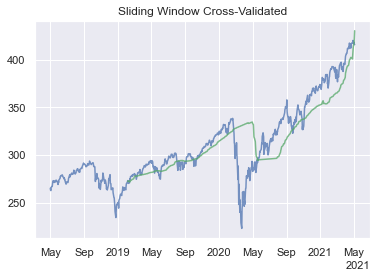

In [43]:
plt.plot(df_3Y_close.index, df_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Sliding Window Cross-Validated")
plt.show()

#### Rolling

In [44]:
half_index = round(df_3Y_close.size/2)

In [45]:
est = pm.ARIMA(order = best_arima.order, intercept=False)
# est = pipe
# cannot use pipeline
cv = pm.model_selection.RollingForecastCV(initial=half_index)
# cannot return conf_int, even with return_conf_int=True
predictions = pm.model_selection.cross_val_predict(
    est, df_3Y_close.interpolate(), cv=cv, verbose=1, averaging="median")


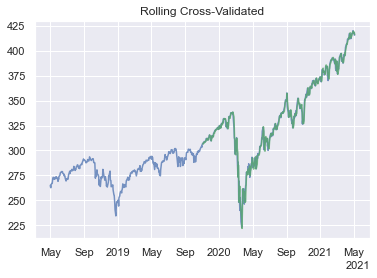

In [46]:
plt.plot(df_3Y_close.index, df_3Y_close.values, alpha=0.75, c='b')
plt.plot(df_3Y_close.index[-predictions.size:], predictions, alpha=0.75, c='g')  # Forecasts
plt.title("Rolling Cross-Validated")
plt.show()

In [47]:
rmse = mse(df_3Y_close.interpolate()[-predictions.size:], predictions)
rmse

24.796568530528145

### Manual Run

In [59]:
train, test = pm.model_selection.train_test_split(df_3Y_close, train_size=80/100)

X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_3Y_close.size))
y_test = test.values

In [53]:
train, test = pm.model_selection.train_test_split(df_3Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_3Y_vol.size))
y_test = test.values

In [383]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
pipe_3f = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=252, k=4)),
    ("fourier2", pm.preprocessing.FourierFeaturizer(m=252/4, k=2)),
    ("fourier3", pm.preprocessing.FourierFeaturizer(m=252*4, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 start_p=0,
                                 start_q=0,
                                 max_p=3,
                                 min_p=0,
                                 max_q=3,
                                 trace=4,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [379]:
# defining a specific model
train, test = pm.model_selection.train_test_split(df_3Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_3Y_close.size))
y_test = test.values
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
pam_3Y_test_pipe = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=252)),
                ('fourier5', pm.preprocessing.FourierFeaturizer(k=2, m=252/4)),
                ('fourier6', pm.preprocessing.FourierFeaturizer(k=4, m=252*4)),
                ('log', pm.preprocessing.LogEndogTransformer()),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t', with_intercept=True
                         ))])

In [126]:
pipe_1f.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3486.669, Time=1.07 sec
First viable model found (3486.669)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3451.308, Time=2.65 sec
New best model found (3451.308 < 3486.669)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3460.270, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3484.923, Time=0.85 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3442.745, Time=2.84 sec
New best model found (3442.745 < 3451.308)
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3442.809, Time=1.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3444.090, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3447.638, Time=2.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3402.954, Time=3.29 sec
New best model found (3402.954 < 3442.745)
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3401.967, Time=3.32 sec
New best model found (3401.967 < 3402.954)
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3434.484, Time=1.17 sec
 ARIMA(5,1,1)(0,0,0)[0]

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 AutoARIMA(d=1, max_p=20, max_q=10, seasonal=False, start_p=0,
                           start_q=0, trace=4))])

In [372]:
pipe_2f.fit(y_train, X_train)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=63.0)),
                ('arima',
                 ARIMA(order=(3, 1, 2), suppress_warnings=True,
                       with_intercept=False))])

In [385]:
pipe_3f.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3507.016, Time=0.29 sec
First viable model found (3507.016)
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3469.328, Time=1.39 sec
New best model found (3469.328 < 3507.016)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3478.484, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3505.017, Time=1.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3462.036, Time=1.15 sec
New best model found (3462.036 < 3469.328)
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3462.482, Time=1.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3463.545, Time=2.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3466.111, Time=1.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3422.719, Time=3.58 sec
New best model found (3422.719 < 3462.036)
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3421.189, Time=4.77 sec
New best model found (3421.189 < 3422.719)
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3453.174, Time=1.78 sec
 ARIMA(5,1,1)(0,0,0)[0]

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=63.0)),
                ('fourier3', FourierFeaturizer(k=4, m=1008)),
                ('arima',
                 AutoARIMA(d=1, max_p=10, max_q=10, seasonal=False, start_p=0,
                           start_q=0, trace=4))])

Explict model pipe passed: 
       ARIMA_Order  Mod_Order Trend  Intercept  Date  Fourier Fourier_m  \
Model                                                                    
0       (3, 1, 2)          5  None      False  True     True       252   

      Fourier_k  BoxCox    Log  Scored        AIC    RMSE   RMSE%   SMAPE  \
Model                                                                       
0             4   False  False    True  4221.4653  3.5926  1.2280  0.7529   

       CV_Time  
Model           
0      92.9395  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('arima',
                 ARIMA(order=(3, 1, 2), suppress_warnings=True,
                       with_intercept=False))])
Starting step-wise cross-validation on adhoc model....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 4221.465
Test RMSE: 3.593
This is 1.228% of the avg observed value.
Test SMAPE: 0.753%

Adding a new score to file... Model not already present in file. Appending model scores to file. 


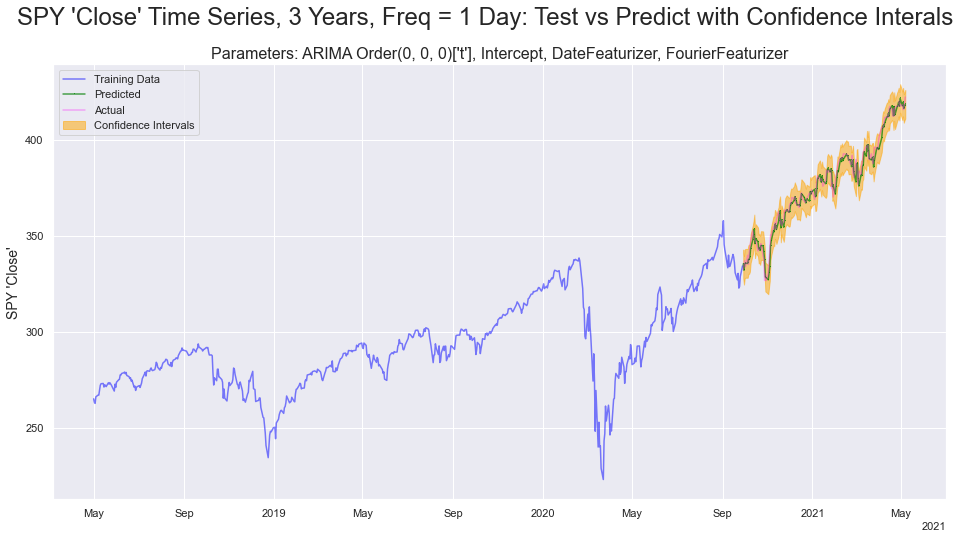

In [371]:
scores1 = pam_3Y_close.run_stepwise_CV(pipe_1f, func='adhoc', dynamic=False, verbose=1, visualize=True)

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..
Explict model pipe passed: 
       ARIMA_Order  Mod_Order Trend  Intercept  Date  Fourier  Fourier_m  \
Model                                                                     
0       (3, 1, 2)          5  None      False  True     True  252, 63.0   

      Fourier_k  BoxCox    Log  Scored        AIC    RMSE   RMSE%   SMAPE  \
Model                                                                       
0          4, 2   False  False    True  4221.4653  3.5926  1.2280  0.7529   

       CV_Time  
Model           
0      83.7930  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=63.0)),
                ('arima',
                 ARIMA(order=(3, 1, 2), suppress_warnings=True,
                       with_intercept=

> 
Done.
Test AIC: 4224.273
Test RMSE: 3.578
This is 1.223% of the avg observed value.
Test SMAPE: 0.749%

Adding a new score to file... Model not already present in file. Appending model scores to file. 


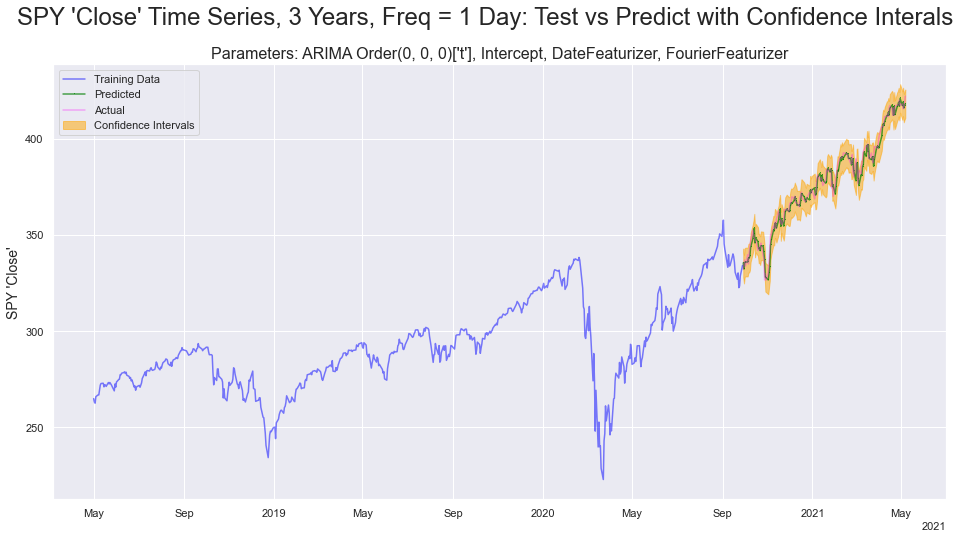

In [377]:
scores2 = pam_3Y_close.run_stepwise_CV(pipe_2f, func='adhoc', dynamic=False, verbose=1, visualize=True)

Explict model pipe passed: 
       ARIMA_Order  Mod_Order Trend  Intercept  Date  Fourier        Fourier_m  \
Model                                                                           
0       (3, 1, 2)          5  None      False  True     True  252, 63.0, 1008   

      Fourier_k  BoxCox    Log  Scored        AIC    RMSE   RMSE%   SMAPE  \
Model                                                                       
0       4, 2, 4   False  False    True  4221.4653  3.5926  1.2280  0.7529   

       CV_Time  
Model           
0      73.4199  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier2', FourierFeaturizer(k=2, m=63.0)),
                ('fourier3', FourierFeaturizer(k=4, m=1008)),
                ('arima',
                 ARIMA(order=(3, 1, 2), suppress_warnings=True,
                       with_intercept=False))])
Starting step-wise cross-validation on adhoc mod

> 
Done.
Test AIC: 4310.028
Test RMSE: 4.493
This is 1.536% of the avg observed value.
Test SMAPE: 0.965%

Adding a new score to file... Model not already present in file. Appending model scores to file. 


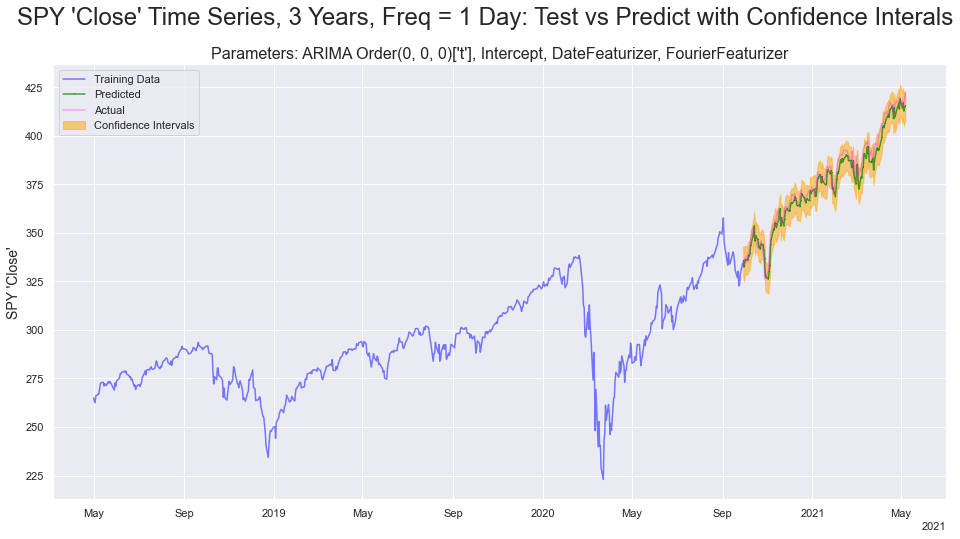

In [386]:
scores3 = pam_3Y_close.run_stepwise_CV(pipe_3f, func='adhoc', dynamic=False, verbose=1, visualize=True)

Explict model pipe passed: 
       ARIMA_Order  Mod_Order Trend  Intercept  Date  Fourier        Fourier_m  \
Model                                                                           
0       (0, 1, 0)          0     t       True  True     True  252, 63.0, 1008   

      Fourier_k  BoxCox   Log  Scored        AIC    RMSE   RMSE%   SMAPE  \
Model                                                                      
0       4, 2, 4   False  True    True  4310.0283  4.4931  1.5358  0.9653   

        CV_Time  
Model            
0      112.1526  
Pipeline: 
 Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=252)),
                ('fourier5', FourierFeaturizer(k=2, m=63.0)),
                ('fourier6', FourierFeaturizer(k=4, m=1008)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))]

> 
Done.
Test AIC: -4208.836
Test RMSE: 4.855
This is 1.659% of the avg observed value.
Test SMAPE: 1.064%

Adding a new score to file... Model not already present in file. Appending model scores to file. 


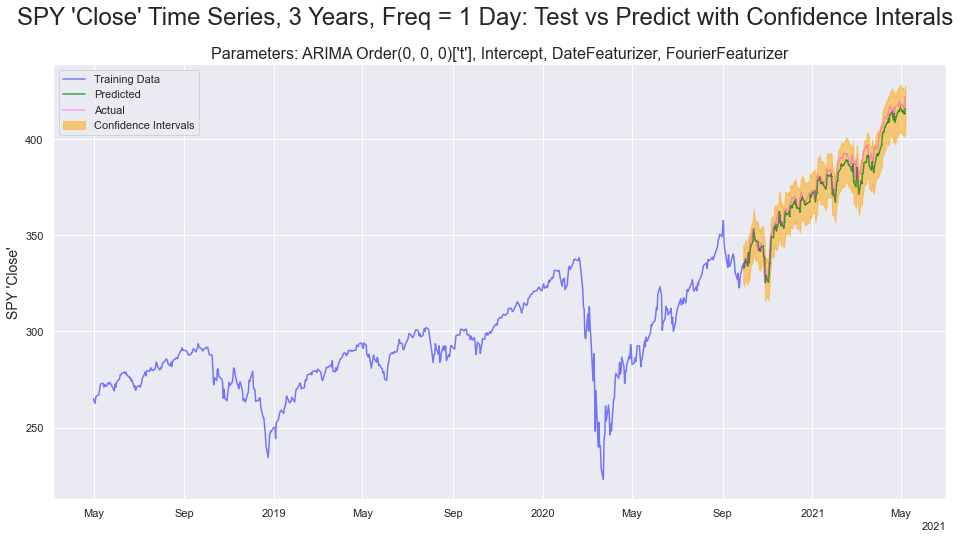

In [387]:
scores4 = pam_3Y_close.run_stepwise_CV(pam_3Y_test_pipe, func='adhoc', dynamic=False, verbose=1, visualize=True)

In [61]:
y_hat = pipe.predict(X=X_test)

Text(0, 0.5, "(SPY 'Volume'")

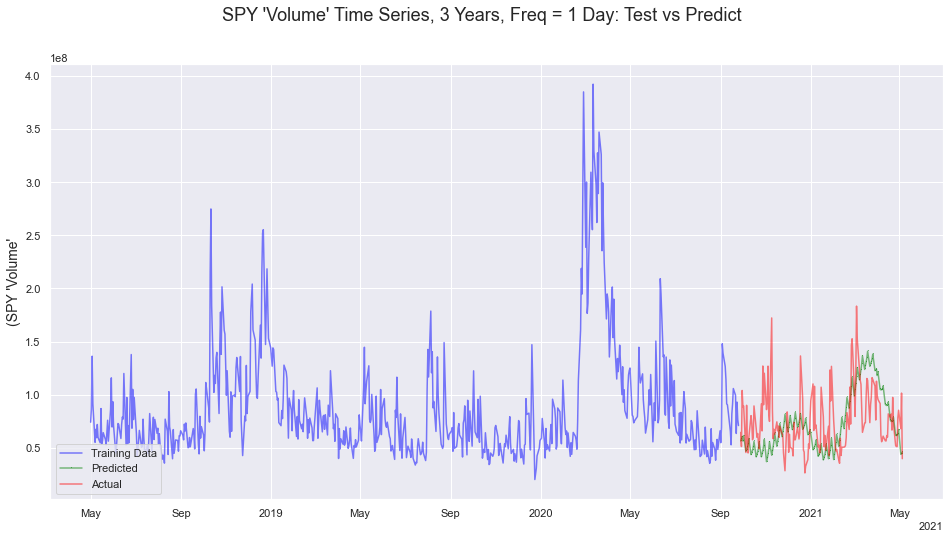

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
ax.plot(X_test, y_test, color='red', alpha=0.5, label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict\n', size=18)
# ax.set_title(f'Parameters: {params}', size=16)
ax.set_ylabel('(SPY \'Volume\'', size=14)

### Test out Stepwise CV

In [69]:
y_hat, conf_ints = pipe.predict(X=X_test, return_conf_int=True)

In [72]:
date = X_test.iloc[0].date + CBD
conf_int = np.asarray(conf_ints)

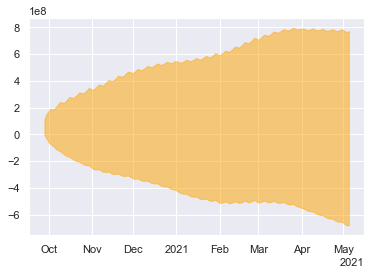

In [73]:
fig, ax = plt.subplots()
ax.fill_between(X_test.date,
               conf_int[:, 0], conf_int[:, 1],
               alpha=0.5, color='orange',
               label="Confidence Intervals")

Text(0, 0.5, "SPY 'Volume'")

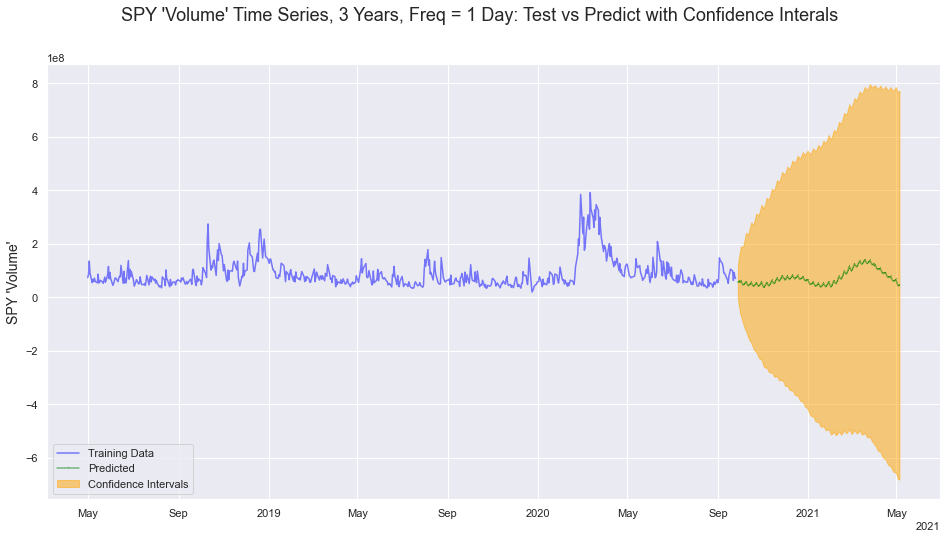

In [76]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(X_train, y_train, color='blue', alpha=0.5, label='Training Data')
ax.plot(X_test, y_hat, color='green', marker=',', alpha=0.5, label='Predicted')
conf_int = np.asarray(conf_ints)
ax.fill_between(X_test.date,
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.5, color='orange',
         label="Confidence Intervals")
ax.legend(loc='lower left', borderaxespad=0.5)
fig.suptitle(f'SPY \'Volume\' Time Series, 3 Years, Freq = 1 Day: Test vs Predict with Confidence Interals\n', size=18)
ax.set_ylabel('SPY \'Volume\'', size=14)

## Last 5 Years, 1 Day

In [78]:
pam_5Y = Pmdarima_Model(df_5Y_close, 'SPY \'Close\'',
               n=3, periods='years', freq='1 Day', seas=261, f_seas=261, fit_seas=False,
               estimate_diffs=True, train_size=80, impute=False, verbose=1,
               date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


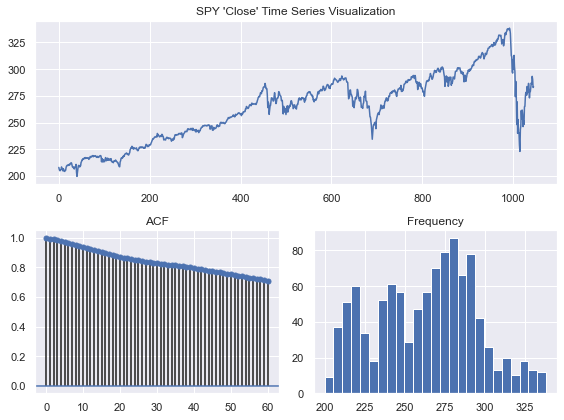

Using DateFeaturizer.
Using FourierFeaturizer.
Parameters for Pipeline: 
[('date', DateFeaturizer(column_name='date')), ('fourier', FourierFeaturizer(k=4, m=261)), ('arima', AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))]

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5307.677, Time=3.28 sec
First viable model found (5307.677)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5379.218, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5327.182, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5338.783, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5377.775, Time=1.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5309.119, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5315.818, Time=4.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5242.366, Time=3.95 sec
New best model found (5242.366 < 5307.677)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5261.495, Time=2.98 sec
Near non-invertible roots for order (4, 1, 2)(0, 0, 0,

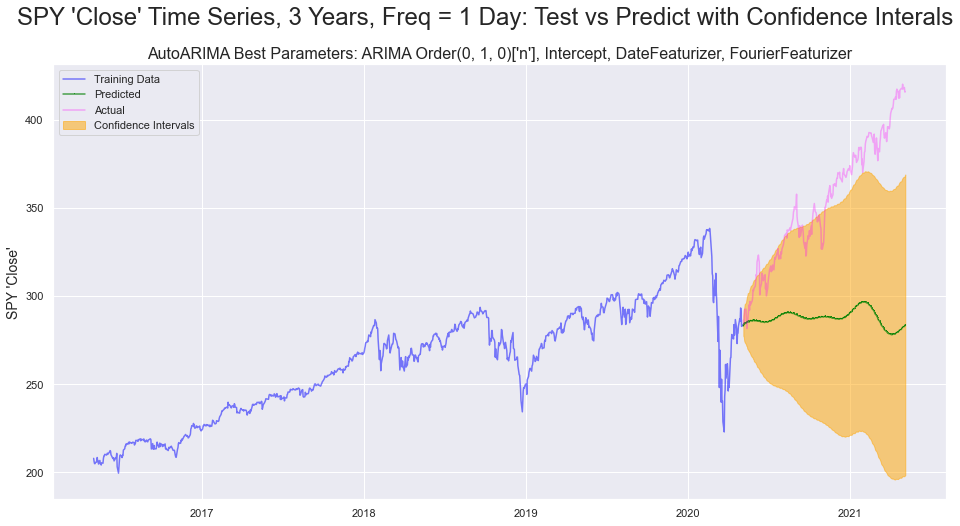

In [81]:
pam_5Y_close = pam_5Y.run_auto_pipeline(show_summary=True, visualize=True)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=3))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 6688.366
Test RMSE: 3.681
This is 1.399% of the avg observed value.
Test SMAPE: 0.819%



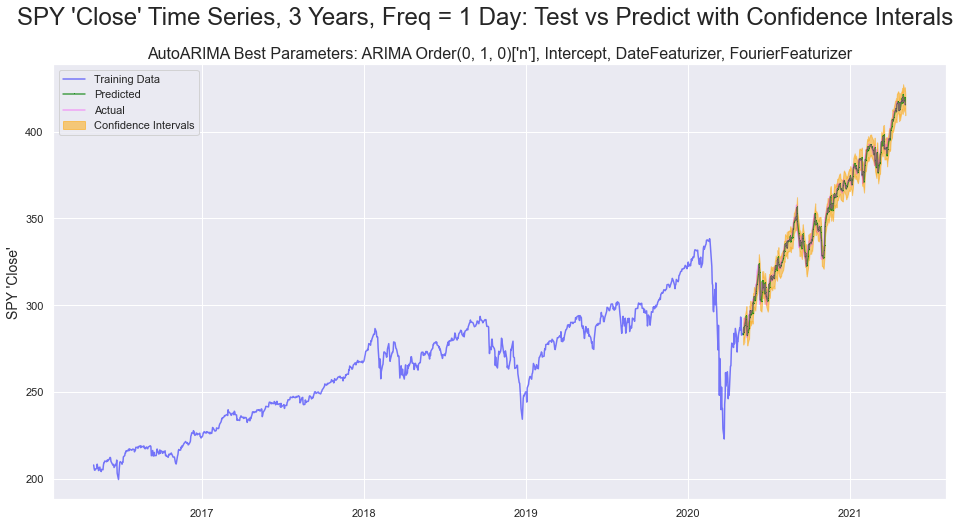

In [82]:
AIC, RMSE, SMAPE = pam_5Y.run_stepwise_CV(dynamic=False, visualize=True)

In [ ]:
pam_5Y_best = pam_5Y.run_gridsearch_CV(debug=True)

## Last 10 Years, 1 Day

In [112]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


In [144]:
pam_10_pipe.named_steps['fourier'].m

261

Starting AutoARIMA...
Data set diffs to use: 1
Parameters for Pipeline: 
AutoARIMA, Intercept, DateFeaturizer, FourierFeaturizer

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8004.127, Time=20.55 sec
First viable model found (8004.127)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8008.863, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8009.629, Time=1.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8009.579, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8010.938, Time=1.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8003.929, Time=16.26 sec
New best model found (8003.929 < 8004.127)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8010.773, Time=3.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8000.441, Time=9.79 sec
New best model found (8000.441 < 8003.929)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8002.387, Time=50.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8010.858, Time=1.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=

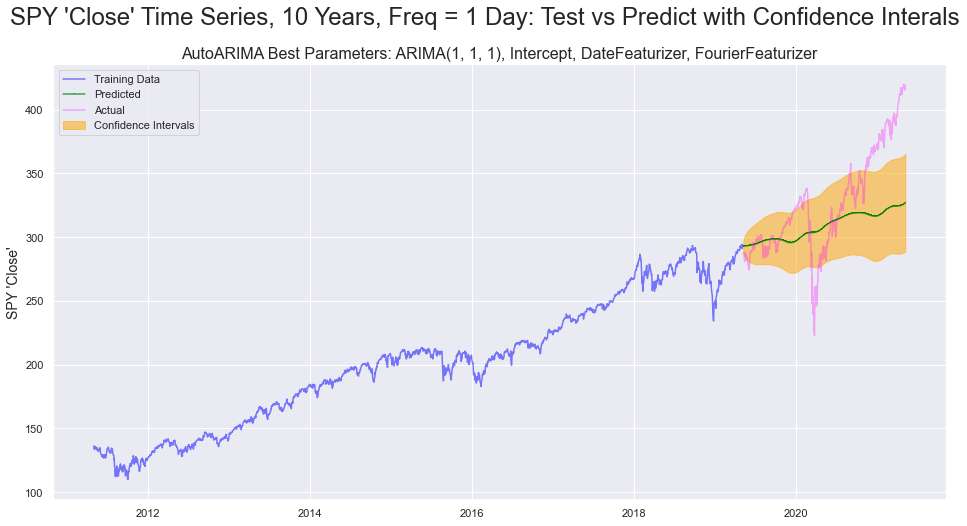

In [116]:
pam_10_pipe = pam_10Y_close.run_auto_pipeline(verbose=1, visualize=True)

### GridSearch

Starting GridSearchCV...
ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['c'], Intercept

_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12009.023 | RMSE: 4.660 | SMAPE 0.982%
Model[ARIMA Order(0, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12009.023 | RMSE=4.660 | SMAPE=0.982%
First viable model found, RMSE=4.660
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12006.112 | RMSE: 4.657 | SMAPE 0.978%
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12006.112 | RMSE=4.657 | SMAPE=0.978%
Next best model found, RMSE=4.657
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12009.829 | RMSE: 4.648 | SMAPE 0.976%
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12009.829 | RMSE=4.648 | SMAPE=0.976%
Next best model found, RMSE=4.648
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12011.439 | RMSE: 4.655 | SMAPE 0.978%
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12011.439 | RMSE=4.655 | SMAPE=0.978%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11957.270 | RMSE: 4.607 | SMAPE 0.972%
Model[ARIMA Order(0, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11957.270 | RMSE=4.607 | SMAPE=0.972%
Next best model found, RMSE=4.607
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11952.623 | RMSE: 4.602 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11952.623 | RMSE=4.602 | SMAPE=0.967%
Next best model found, RMSE=4.602
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11959.192 | RMSE: 4.604 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11959.192 | RMSE=4.604 | SMAPE=0.967%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11964.814 | RMSE: 4.649 | SMAPE 0.968%
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11964.814 | RMSE=4.649 | SMAPE=0.968%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11921.140 | RMSE: 4.586 | SMAPE 0.967%
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.140 | RMSE=4.586 | SMAPE=0.967%
Next best model found, RMSE=4.586
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11917.914 | RMSE: 4.583 | SMAPE 0.963%
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11917.914 | RMSE=4.583 | SMAPE=0.963%
Next best model found, RMSE=4.583
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11920.300 | RMSE: 4.569 | SMAPE 0.960%
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11920.300 | RMSE=4.569 | SMAPE=0.960%
Next best model found, RMSE=4.569
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11925.531 | RMSE: 4.623 | SMAPE 0.966%
Model[ARIMA Order(0, 1, 2)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11925.531 | RMSE=4.623 | SMAPE=0.966%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11945.625 | RMSE: 4.596 | SMAPE 0.970%
Model[ARIMA Order(1, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11945.625 | RMSE=4.596 | SMAPE=0.970%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11940.890 | RMSE: 4.590 | SMAPE 0.965%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11940.890 | RMSE=4.590 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11944.217 | RMSE: 4.617 | SMAPE 0.965%
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11944.217 | RMSE=4.617 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11946.553 | RMSE: 4.614 | SMAPE 0.964%
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11946.553 | RMSE=4.614 | SMAPE=0.964%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11934.953 | RMSE: 4.677 | SMAPE 0.987%
Model[ARIMA Order(1, 1, 1)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11934.953 | RMSE=4.677 | SMAPE=0.987%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12005.407 | RMSE: 4.662 | SMAPE 0.986%
Model[ARIMA Order(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12005.407 | RMSE=4.662 | SMAPE=0.986%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 12537.598 | RMSE: 4.637 | SMAPE 0.973%
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12537.598 | RMSE=4.637 | SMAPE=0.973%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 13051.724 | RMSE: 4.640 | SMAPE 0.975%
Model[ARIMA Order(1, 1, 1)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=13051.724 | RMSE=4.640 | SMAPE=0.975%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11925.444 | RMSE: 4.591 | SMAPE 0.967%
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11925.444 | RMSE=4.591 | SMAPE=0.967%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11921.800 | RMSE: 4.587 | SMAPE 0.963%
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.800 | RMSE=4.587 | SMAPE=0.963%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11924.492 | RMSE: 4.606 | SMAPE 0.965%
Model[ARIMA Order(2, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11924.492 | RMSE=4.606 | SMAPE=0.965%
_____________________________________________________________________

Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
AIC: 11927.843 | RMSE: 4.589 | SMAPE 0.961%
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11927.843 | RMSE=4.589 | SMAPE=0.961%

GridsearchCV Completed.

Top 10 models:
Model[ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11920.300 | RMSE=4.569 | SMAPE=0.960%
Model[ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11917.914 | RMSE=4.583 | SMAPE=0.963%
Model[ARIMA Order(0, 1, 2)['n'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.140 | RMSE=4.586 | SMAPE=0.967%
Model[ARIMA Order(2, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11921.800 | RMSE=4.587 | SMAPE=0.963%
Model[ARIMA Order(2, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11927.843 | RMSE=4.589 | SMAPE=0.961%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11940.890 | RMSE=4.590 | SMAPE=0.965%
Model[ARIMA Order(2, 1, 0)['n'], Intercept, DateFe

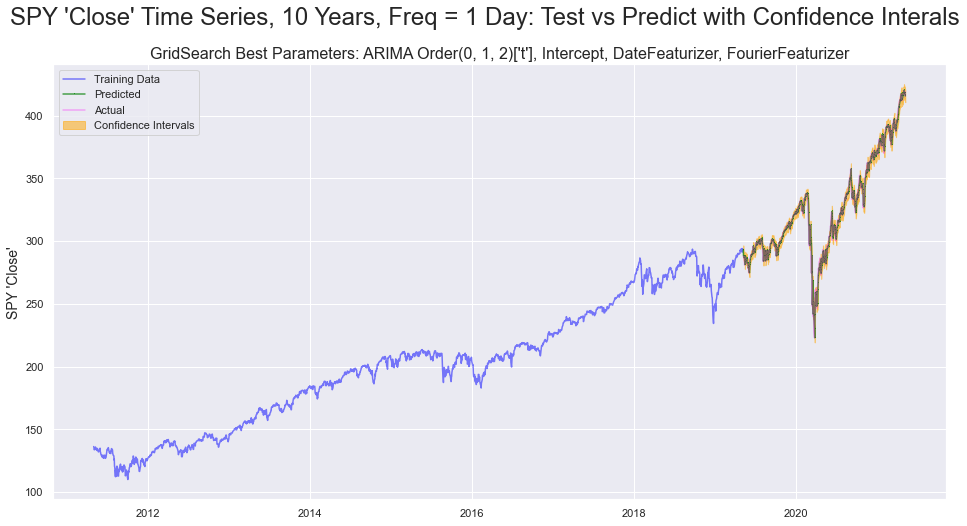

In [121]:
# Using an abbreviated set of params
pam_10Y_best, scores = pam_10Y_close.run_gridsearch_CV(max_order=2, max_d=2,
#                                                  t_list=['t'],
                                                 fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

In [122]:
Audio(sound_file, autoplay=True)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from {top}/data..


Pmdarima_Model.py loaded.
ARIMA(1, 1, 1), Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_

> 
Done.
Test AIC: 12005.407
Test RMSE: 4.662
This is 2.322% of the avg observed value.
Test SMAPE: 0.986%



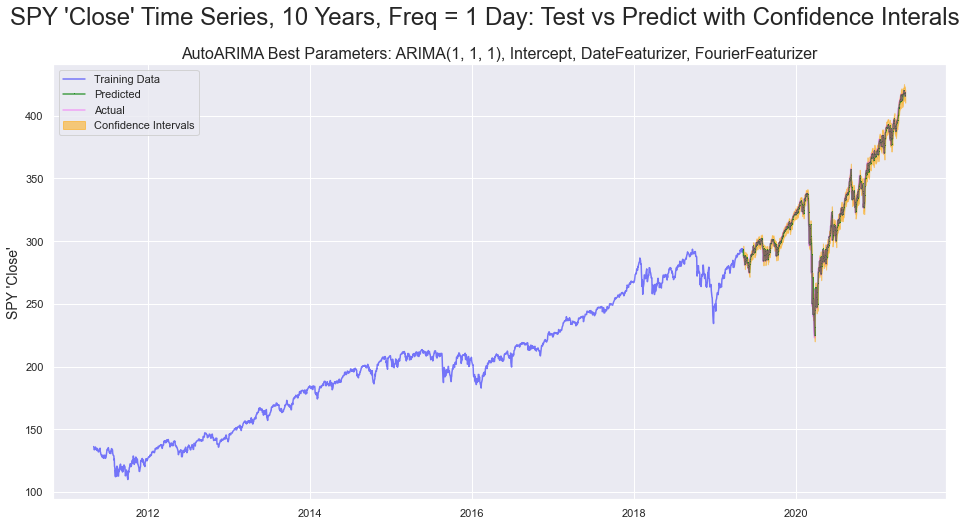

In [120]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_best, func='GS', dynamic=False, verbose=1, visualize=True)

Pmdarima_Model.py loaded.


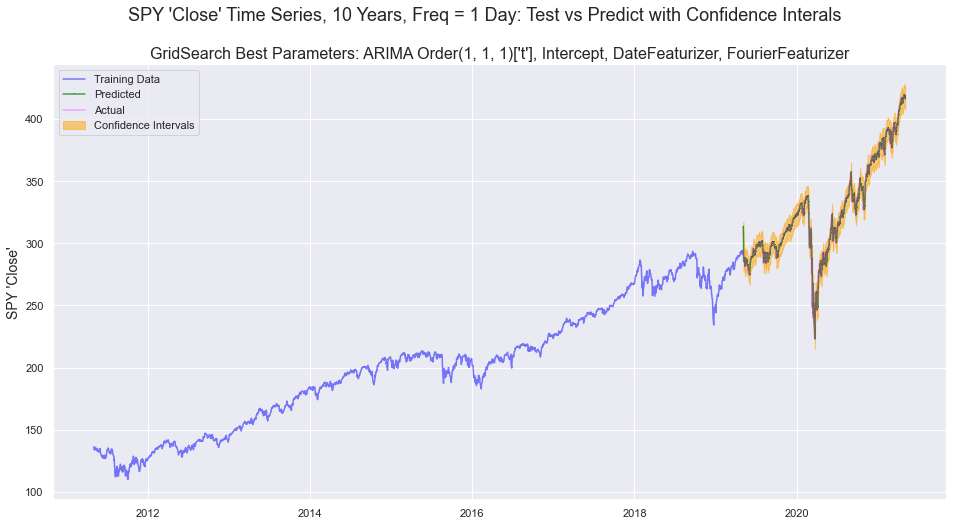

In [152]:
pam_10Y_close.plot_test_predict(pam_10Y_close.y_hat, func='GS', conf_ints=pam_10Y_close.conf_ints)

In [ ]:
AIC, RMSE, SMAPE = pam_10Y_close.run_stepwise_CV(pam_10Y_close.GS_best_mod_pipe, dynamic=False, verbose=1, visualize=True)

#### Manual Run

In [ ]:
dates_10Y = pd.DataFrame(df_10Y_close.index, columns=['date'])
dates_10Y

In [57]:
date_df = new_dates_10Y_df[0:1]
date_df

date
2613 2021-05-06 14:34:29.418608

##### Close Only

In [49]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [50]:
pam_10Y_close.fit(df_10Y_close, dates_10Y)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])

In [58]:
# close_hat, close_conf_ints = pam_10Y_close.predict(X=new_dates_df, return_conf_int=True)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([416.04524828])

In [523]:
close_conf_ints

array([[409.31738871, 418.92767348]])

In [59]:
pam_10Y_close = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=261)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='t'))])
pam_10Y_close.fit(df_10Y_close, dates_10Y)
close_hat, close_conf_ints = pam_10Y_close.predict(X=date_df, return_conf_int=True)
close_hat

array([415.9116414])

##### Volume

In [ ]:
pam_10Y_vol.fit(df_10Y_vol, dates_10Y)

In [ ]:
vol_hat, vol_conf_ints = pam_10Y_vol.predict(X=new_dates_df, return_conf_int=True)
vol_hat

In [ ]:
vol_hat_df = pd.DataFrame(vol_hat, index=index_fc, columns=['volume'])
vol_hat_df = vol_hat_df.join(new_dates_df)
vol_hat_df

In [96]:
train, test = pm.model_selection.train_test_split(df_10Y_close, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
# X_test = pd.DataFrame(test.index)
X_test = pd.DataFrame(test.index, index=range(X_train.size, pam_10Y_close.length))
y_test = test.values

X_test

date
2090 2019-05-06
2091 2019-05-07
2092 2019-05-08
2093 2019-05-09
2094 2019-05-10
...         ...
2608 2021-04-29
2609 2021-04-30
2610 2021-05-03
2611 2021-05-04
2612 2021-05-05

[523 rows x 1 columns]

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='c'))])
Starting step-wise cross-validation...
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 730.867
Test RMSE: 31034500.027
This is 25.950% of the avg observed value.
Test SMAPE: 22.808%



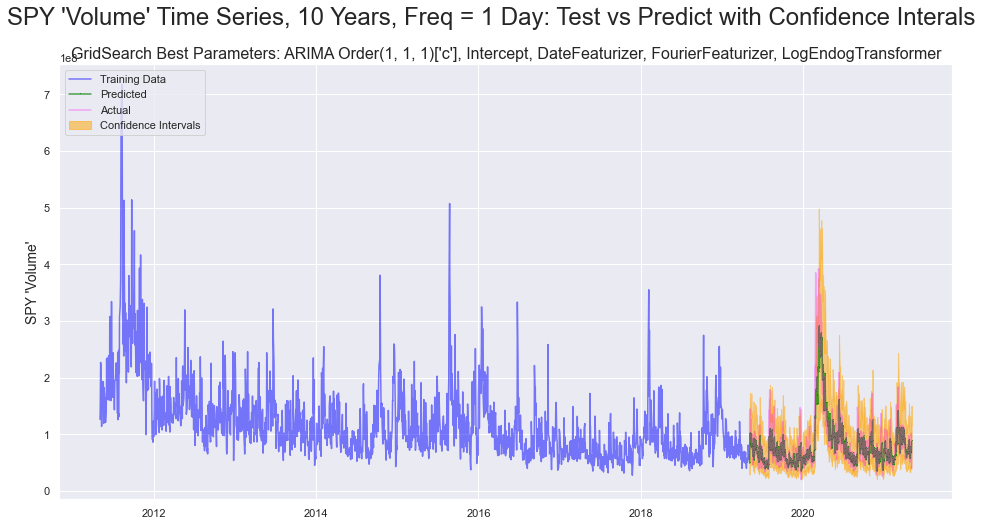

In [31]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(pam_10Y_vol_best, func='GS', dynamic=False, verbose=1, visualize=True)

In [33]:
pam_10Y_vol.y_hat

[49278028.8340929,
 82449731.30611807,
 101984583.51983163,
 80500324.25265357,
 92292008.34662569,
 78444889.21737492,
 100886386.30734552,
 80000935.58004633,
 76836001.5210743,
 82881419.30917634,
 76838319.05785337,
 70798961.88253729,
 60972670.820110105,
 60569060.58712146,
 92562203.48496078,
 54404790.1944264,
 67845140.0538666,
 73363562.7290432,
 90305556.69966596,
 72910096.03651996,
 72030314.06895778,
 88654665.88851836,
 81031001.12236844,
 76108807.98490693,
 79104752.01485673,
 65397294.18135849,
 68664931.36522743,
 68237528.9421217,
 58790742.089202955,
 62337002.7220155,
 50956061.28060004,
 50412105.49324121,
 77532351.71062009,
 73625690.61985487,
 97322340.84881155,
 66063103.48767689,
 57342196.63155666,
 77722317.71181978,
 59560014.24131452,
 54185186.77820849,
 54304261.638268776,
 72921728.02036957,
 65259186.134099156,
 51001442.313262865,
 56468662.6432633,
 47271553.34218468,
 51583688.404506505,
 48846367.50482711,
 57472925.041389994,
 56189179.28738522,

Pmdarima_Model.py loaded.


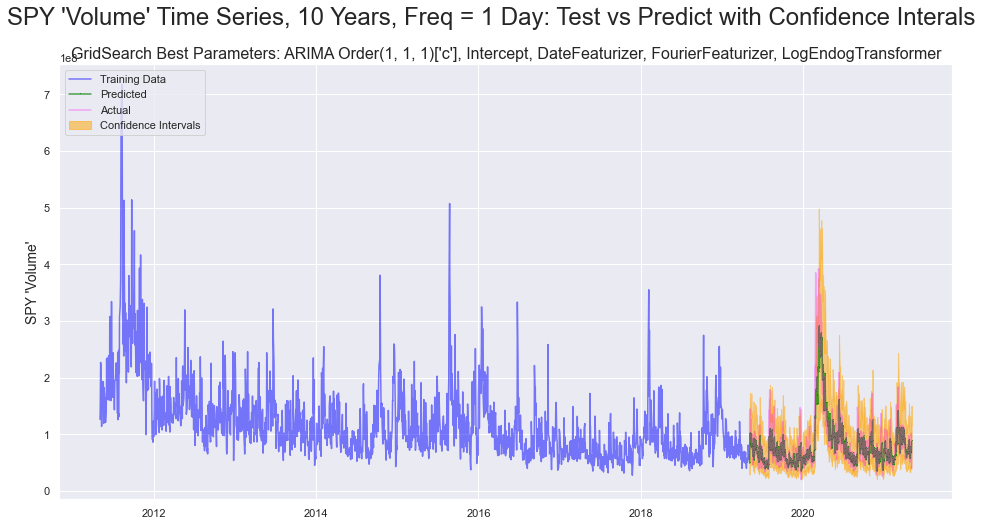

In [34]:
pam_10Y_vol.plot_test_predict(y_hat=pam_10Y_vol.y_hat, conf_ints=True, func='GS')
# AIC, RMSE, SMAPE = pam_10Y_vol.plot_test_predict(conf_ints=pam_10Y_vol.conf_ints, func='GS')

### Manual Forecast

In [ ]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
# _, X_train_feats = date_feat.fit_transform(y_train, X_train)
_, X_train_feats = date_feat.fit_transform(df_10Y_close, dates_10Y)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [ ]:
vol_10Y_df = pd.DataFrame(df_10Y_vol).reset_index()

In [ ]:
full_10Y_pipe.fit(df_10Y_close, vol_10Y_df)

In [ ]:
close_vol_hat, close_vol_conf_ints = full_10Y_pipe.predict(X=vol_hat_df, return_conf_int=True)
close_vol_hat

In [203]:
close_vol_hat = np.asarray([414.79630855, 414.60707979, 414.48872733, 414.77080045,
       414.65227317])

#### Plot

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)

In [ ]:
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
new_fc_df = pd.DataFrame(zip(new_dates_df.date.values,close_vol_hat), columns=['date','close'])
new_fc_df.set_index('date', inplace=True)
spy_df_10Y_fc = spy_df_10Y.append(new_fc_df)

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(24, 16))
mpl.plot(spy_df_10Y[-120:],
         type='candle',
         style="yahoo",
         ax=ax,
         )
ax.plot(range(120,125), close_vol_hat, 'g.', markersize=10, alpha=0.7, label='Forecast')
# conf_int = np.asarray(close_vol_conf_ints)
conf_int = close_vol_conf_ints
ax.fill_between(range(120,125),
         conf_int[:, 0], conf_int[:, 1],
         alpha=0.3, color='orange',
         label="Confidence Intervals")
ax.set_xlim(0, 130)
ax.set_ylabel('Closing Price (USD)', size=16)
ax.set_title('Using ARIMA(3,1,2), FourierFeaturizer', size=18)
equidate_ax(fig, ax, spy_df_10Y_fc[-125:].index.date)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.subplots_adjust(top=0.92)
ax.legend(loc='upper left', borderaxespad=0.5, fontsize = 18)
fig.suptitle(f'{ylabel} Time Series, 10 Years, Freq = 1 Day: Historical vs Forecast with Confidence Interals\n', size=24)

### Stepwise CV

In [437]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
full_10Y_pipe = pipeline.Pipeline([
    ('date', date_feat),
    ("fourier", pm.preprocessing.FourierFeaturizer(m=261, k=4)),
    ('arima', pm.arima.AutoARIMA(d=1,
                                 trace=3,
                                 stepwise=True,
                                 suppress_warnings=True,
                                 seasonal=False))
])

In [454]:
# full_10Y_pipe.fit(df_10Y_close.values, pd.DataFrame(df_10Y_close.index))
# full_10Y_pipe.fit(df_10Y_close.values, dates_10Y)
full_10Y_pipe.fit(y_test, X_test)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3051.921, Time=1.07 sec
First viable model found (3051.921)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3090.663, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3059.319, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3067.151, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3090.010, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3050.890, Time=0.85 sec
New best model found (3050.890 < 3051.921)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3049.213, Time=0.79 sec
New best model found (3049.213 < 3050.890)
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3050.648, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3057.010, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3050.165, Time=2.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3048.629, Time=0.78 sec
New best model found (3048.629 < 3049.213)
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3067.371, Time=0.66 sec


Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=4, m=261)),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

In [467]:
# RMSE = mse(df_10Y_close, y_hat, squared=False)
RMSE = mse(test, y_hat, squared=False)
print("Test RMSE: %.2f" % RMSE)
print("This is %.2f%% of the avg observed value." % (100*RMSE/y_train.mean()))
print("Test SMAPE: %.2f%%\n" % smape(test, y_hat))
# print("Test SMAPE: %.2f%%\n" % smape(df_10Y_close, y_hat))

Test RMSE: 10.95
This is 5.46% of the avg observed value.
Test SMAPE: 1.07%



In [468]:
fc, conf_ints = model.predict(X=new_dates_df, return_conf_int=True)

In [469]:
fc

array([416.95933521, 413.52184596, 409.9202409 , 406.34035504,
       406.80537236])

In [470]:
conf_ints

array([[392.61884771, 441.2998227 ],
       [379.31263146, 447.73106046],
       [367.90927322, 451.93120859],
       [357.76492447, 454.9157856 ],
       [352.4526033 , 461.15814141]])

### Programmatically Forecasting

In [129]:
# defining a specific model
train, test = pm.model_selection.train_test_split(df_10Y_vol, train_size=80/100)
X_train = pd.DataFrame(train.index)
y_train = train.values
X_test = pd.DataFrame(test.index, index=range(X_train.size, df_10Y_vol.size))
y_test = test.values
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(y_train, X_train)
pam_10Y_vol_new = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=100, m=261)),
                ('log', pm.preprocessing.LogEndogTransformer()),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(1, 1, 2), suppress_warnings=True,
#                        trend='c'
                         ))])

In [131]:
pam_10Y_vol_new.named_steps['arima'].trend

In [208]:
mod_params = 'ARIMA(1, 1, 2), Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer'
AA_best_params = mod_params
trend = None
with_intercept = True
# mod_params.replace('Check ', '')
AA_best_params

'ARIMA(1, 1, 2), Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer'

In [209]:
mod_params.rfind(')')

13

In [116]:
pam_10Y_vol_new.fit(y_train, X_train)

Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=100, m=261)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 2), suppress_warnings=True,
                       trend='c'))])

In [108]:
trend='c'

In [210]:
if with_intercept:
    AA_best_params = mod_params.replace('Check ', '')
    with_intercept = True
    if trend:
        AA_best_params = mod_params.replace(mod_params[mod_params.rfind(')')], f')[\'{trend}\']')
        t = trend
    else:
        AA_best_params = mod_params.replace(mod_params[mod_params.rfind(')')], ')[\'c\']')
        t = 'c'
else:
    AA_best_params = mod_params.replace('Check Intercept', '')
    with_intercept = False

In [211]:
AA_best_params, t

("ARIMA(1, 1, 2)['c'], Check Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer",
 'c')

In [176]:
mod_params.replace(mod_params[mod_params.rfind(')')], f')[\'{trend}\']')

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..


"ARIMA(1, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer"

In [177]:
mod_params.replace(mod_params[mod_params.rfind(')')], ')[\'c\']')

"ARIMA(1, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer"

In [96]:
pam_10Y_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=10, periods='years', freq='1 Day', trend='c', f_seas=252, k=20,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Successfully created instance of Class Pmdarima_Model.


In [120]:
pam_10Y_vol_new.predict(X=X_test)

array([8.87948061e+07, 9.78703420e+07, 8.58354615e+07, 8.26956736e+07,
       6.44082326e+07, 6.81241909e+07, 7.34516184e+07, 7.46254553e+07,
       8.53797743e+07, 7.14766641e+07, 7.04815540e+07, 7.19749662e+07,
       6.95002828e+07, 6.30854994e+07, 5.17394268e+07, 6.18283617e+07,
       6.14590961e+07, 5.55783701e+07, 4.86767468e+07, 5.56250333e+07,
       5.57047373e+07, 5.76019209e+07, 5.90544620e+07, 4.87960818e+07,
       6.11711107e+07, 6.38584646e+07, 6.20095298e+07, 6.57594717e+07,
       4.87711782e+07, 5.30820182e+07, 5.56355577e+07, 5.25604681e+07,
       6.19807667e+07, 5.10889157e+07, 4.55403713e+07, 4.52901442e+07,
       5.28994655e+07, 6.08574234e+07, 4.60183592e+07, 4.95706247e+07,
       5.59847895e+07, 5.63534716e+07, 4.53628268e+07, 4.99952136e+07,
       5.29337181e+07, 5.23568391e+07, 5.11129373e+07, 4.27421608e+07,
       4.80748931e+07, 4.54034393e+07, 4.40818497e+07, 4.74164374e+07,
       3.95686738e+07, 4.99722428e+07, 5.58427049e+07, 5.24361237e+07,
      

Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
 AutoARIMA, Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=20, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=546.544, Time=70.06 sec
First viable model found (546.544)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1117.520, Time=2.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=821.009, Time=10.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=639.431, Time=39.72 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1115.520, Time=9.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=539.309, Time=72.01 sec
New best model found (539.309 < 546.544)
 ARIM

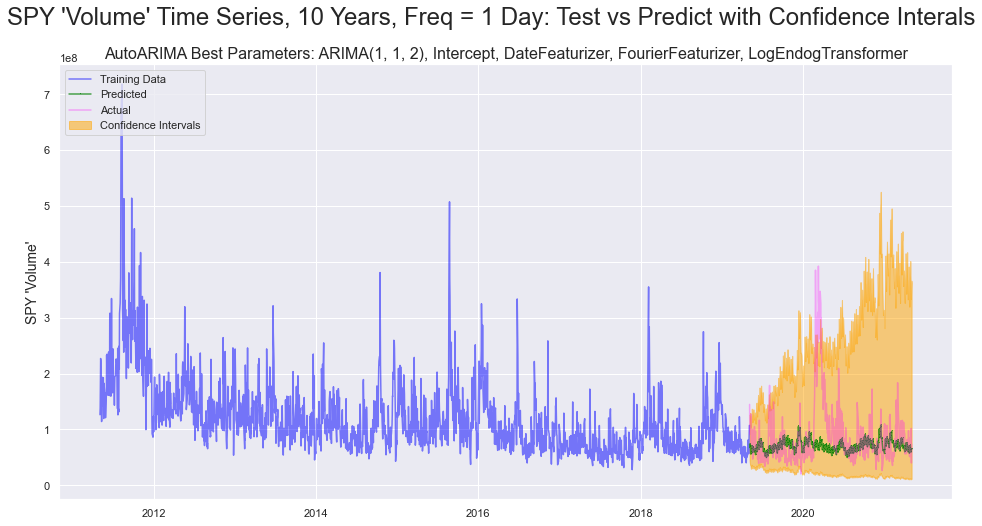

In [97]:
pam_10Y_vol_AA = pam_10Y_vol.run_auto_pipeline(visualize=1, return_conf_int=True, verbose=1)

Functions loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.
ARIMA(1, 1, 2), Intercept, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=20, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=True))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 808.927
Test RMSE: 32755708.707
This is 27.280% of the avg observed value.
Test SMAPE: 24.655%



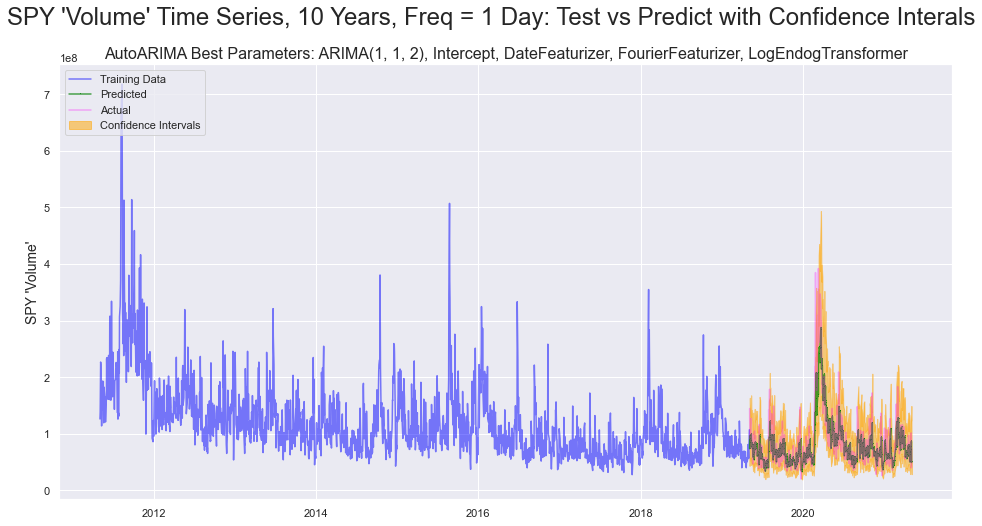

In [98]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [128]:
pam_10Y_vol_new.named_steps['arima'].trend

'c'

In [99]:
Audio(sound_file, autoplay=True)

In [105]:
pam_10Y_vol_AA.named_steps['arima'].model_.trend

In [132]:
pam_10Y_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80, with_intercept=False,
                            n=10, periods='years', freq='1 Day', trend='c', f_seas=252, k=9,
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=True)

Pmdarima_Model.py loaded from {top}/data..
Successfully created instance of Class Pmdarima_Model.


Pmdarima_Model.py loaded from {top}/data..
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=9, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=525.199, Time=43.78 sec
First viable model found (525.199)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.285, Time=4.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=791.227, Time=5.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=633.848, Time=22.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=523.219, Time=42.49 sec
New best model found (523.219 < 525.199)
 ARIMA(0,1,2)(0,0,0)[0]             : A

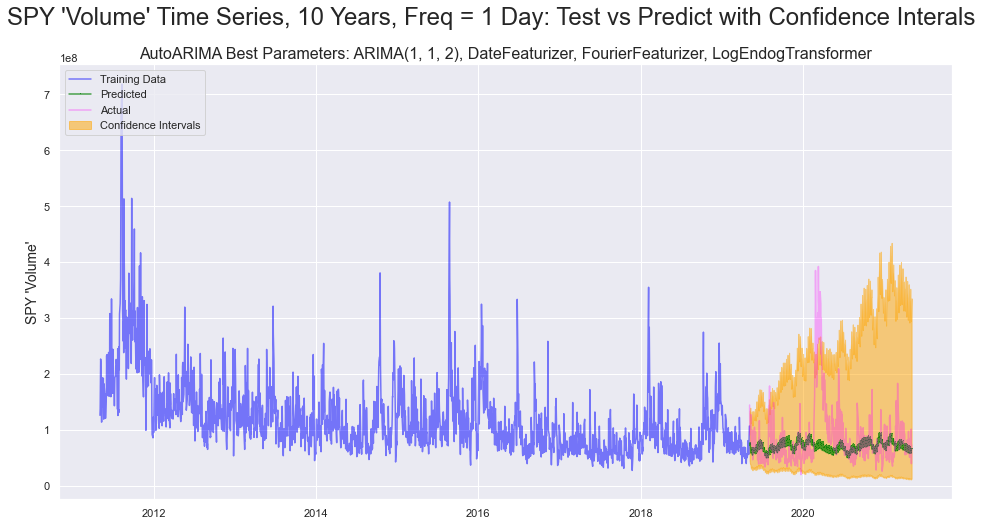

In [134]:
pam_10Y_vol_AA = pam_10Y_vol.run_auto_pipeline(visualize=1, return_conf_int=True, verbose=1)

ARIMA(1, 1, 2), DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=9, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4,
                           with_intercept=False))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Volume' Time Series and updating model, beginning with first index of y_test ...


> 
Done.
Test AIC: 798.875
Test RMSE: 32725006.504
This is 27.254% of the avg observed value.
Test SMAPE: 24.540%



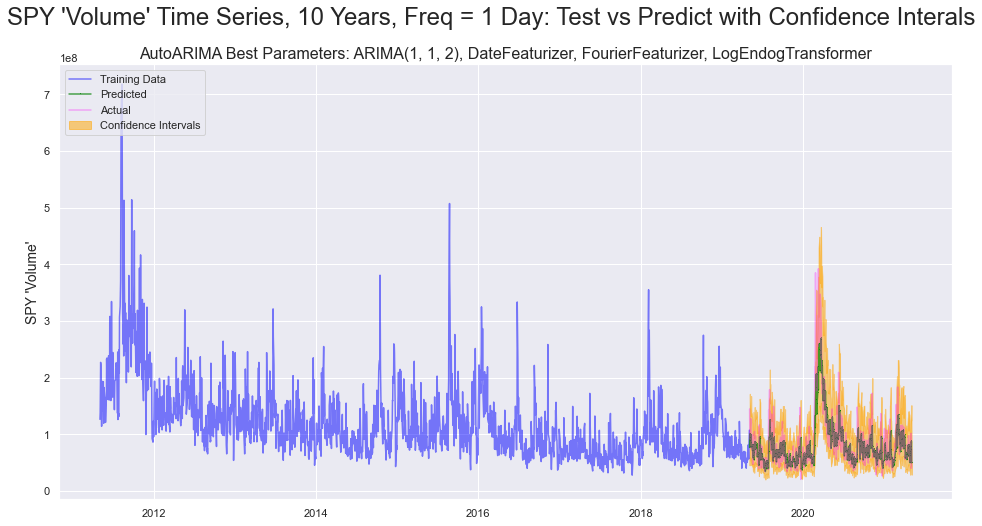

In [143]:
AIC, RMSE, SMAPE = pam_10Y_vol.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [26]:
pam_10Y_vol_best

NameError: name 'pam_10Y_vol_best' is not defined

In [39]:
pam_10Y_vol.AA_mod_pipe.named_steps['arima'].model_.order

(2, 1, 1)

In [ ]:
Audio(sound_file, autoplay=True)

In [136]:
vol_10Y_hat_df, vol_10Y_hat, new_dates_df, vol_10Y_conf_ints = pam_10Y_vol.run_prediction(pam_10Y_vol_best, 12, fin=False,
                            en_ex='exog', hist_df=df_10Y_vol, func='GS', verbose=1)

Successfully created instance of Class Pmdarima_Model.


NameError: name 'pam_10Y_vol_best' is not defined

In [247]:
exog_df = Pmdarima_Model.join_exog_data(new_dates_df, vol_10Y_hat_df)

Successfully created instance of Class Pmdarima_Model.
Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 12 days forward.


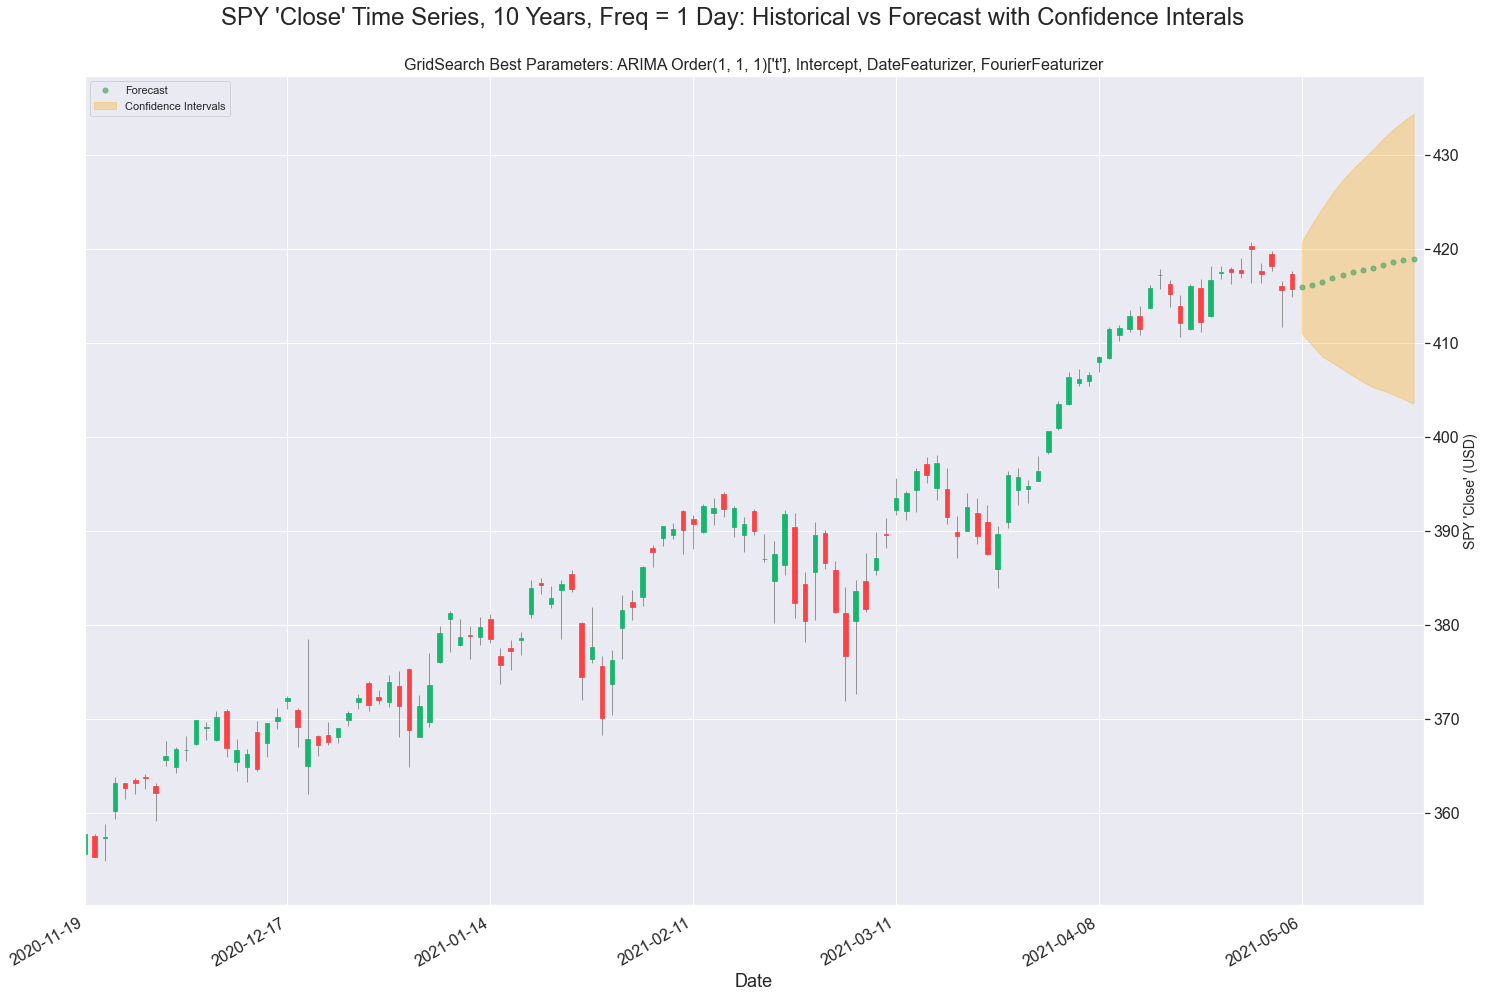

In [248]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, start_order=(1,1,1),
                            n=10, periods='years', freq='1 Day', f_seas=261, seas=261, trend='t',
                            estimate_diffs=True, impute=False, verbose=1,
                            date=True, fourier=True, box=False, log=False)
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_best, 12, fin=True,
                            exog_df=exog_df, en_ex='endo', ohlc_df=spy_df_10Y, func='GS', verbose=1)

## Manual testing of pmdarima

In [86]:
# df_train, df_test = train_test_split_data(df_10Y_close, 80, verbose=1)
df_train, df_test = train_test_split_data(df_3Y_close, 80, verbose=1)

##### Train-Test Split #####
Using a 80/20 train-test split...


In [108]:
new_mod = pm.auto_arima(df_train)

In [109]:
new_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1753.178
Date:                Thu, 06 May 2021   AIC                           3512.355
Time:                        13:47:23   BIC                           3525.688
Sample:                             0   HQIC                          3517.534
                                - 630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1875      0.018    -10.434      0.000      -0.223      -0.152
ma.L2          0.2166      0.017     12.943      0.000       0.184       0.249
sigma2        15.4317      0.343     45.016      0.000      14.760      16.104
===================================================================================
Ljung-Box (Q):                      101.90   Jarque-Bera (JB):              3424.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
y_hat_test.size

158

In [134]:
start = df_train.size
end = df_3Y_close.size

In [140]:
y_hat_train, conf_int_train = new_mod.predict_in_sample(dynamic=False, return_conf_int=True)
y_hat_test, conf_int_test = new_mod.predict_in_sample(start=start, end=end-1, return_conf_int=True)
# y_hat_train, conf_int_train = new_mod.predict_in_sample(X=df_train.index, dynamic=False, return_conf_int=True)
# y_hat_test, conf_int_test = new_mod.predict_in_sample(X=df_test.index, return_conf_int=True)

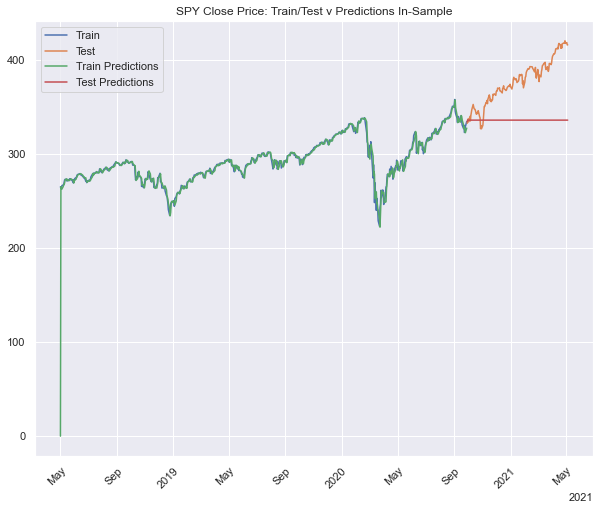

In [141]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='Train')
ax.plot(df_test, label='Test')
ax.plot(df_train.index, y_hat_train, label='Train Predictions')
ax.plot(df_test.index, y_hat_test, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

## All Years, 1 Day

In [136]:
df_all_close

date
1993-01-29     43.937500
1993-02-01     44.250000
1993-02-02     44.343750
1993-02-03     44.812500
1993-02-04     45.000000
                 ...    
2021-05-03    418.200012
2021-05-04    415.619995
2021-05-05    415.750000
2021-05-06    419.070007
2021-05-07    422.119995
Freq: C, Name: close, Length: 7120, dtype: float64

In [154]:
pam_all_close = Pmdarima_Model(df_all_close, 'SPY \'Close\'', train_size=80,
                            n='All', periods='years', freq='1 Day', f_seas=252, seas=252,
                            estimate_diffs=True, impute=False, verbose=1, k=2,
                            date=True, fourier=True, box=False, log=False)

Successfully created instance of Class Pmdarima_Model.


Starting AutoARIMA...
Data set diffs to use: 1


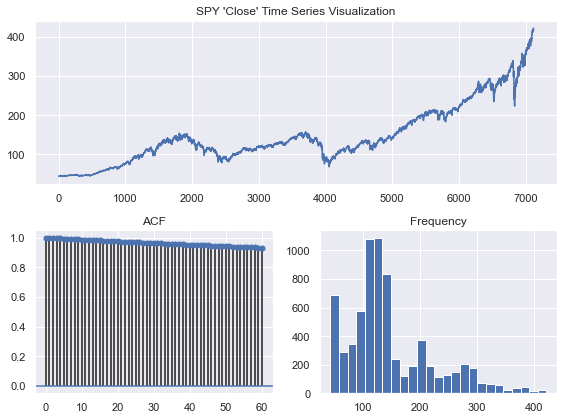

Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19638.228, Time=17.81 sec
First viable model found (19638.228)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19673.523, Time=1.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19661.008, Time=1.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19659.338, Time=3.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19673.768, Time=4.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19636.414, Time=8.33 sec
New best model found (19636.414 < 19638.228)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19645.491, Time=2.80 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19634.942, Time=9.88 sec
New best model 

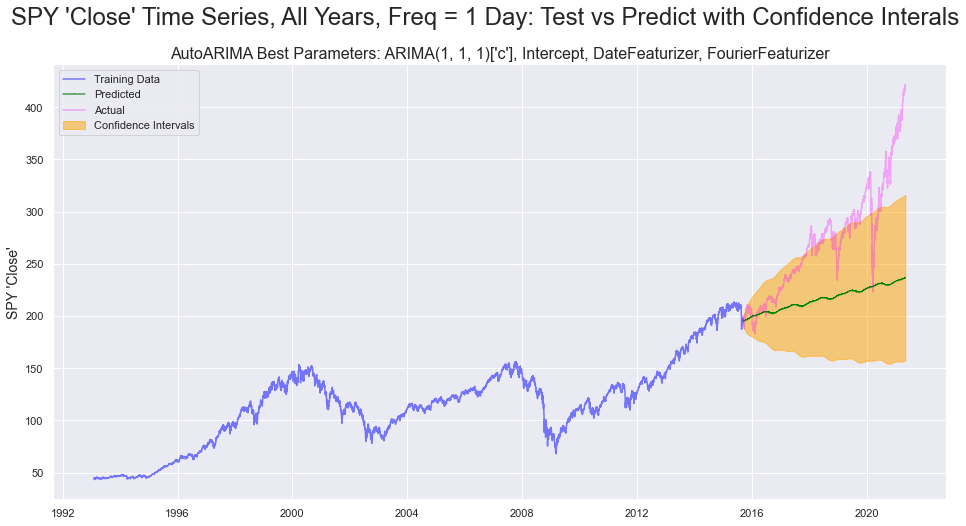

In [155]:
pam_all_close_auto = pam_all_close.run_auto_pipeline(show_summary=True, verbose=1, visualize=True)

ARIMA(1, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))])
Starting step-wise cross-validation on best model from AutoArima....
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
Test AIC: 29096.870
Test RMSE: 3.210
This is 2.784% of the avg observed value.
Test SMAPE: 0.710%




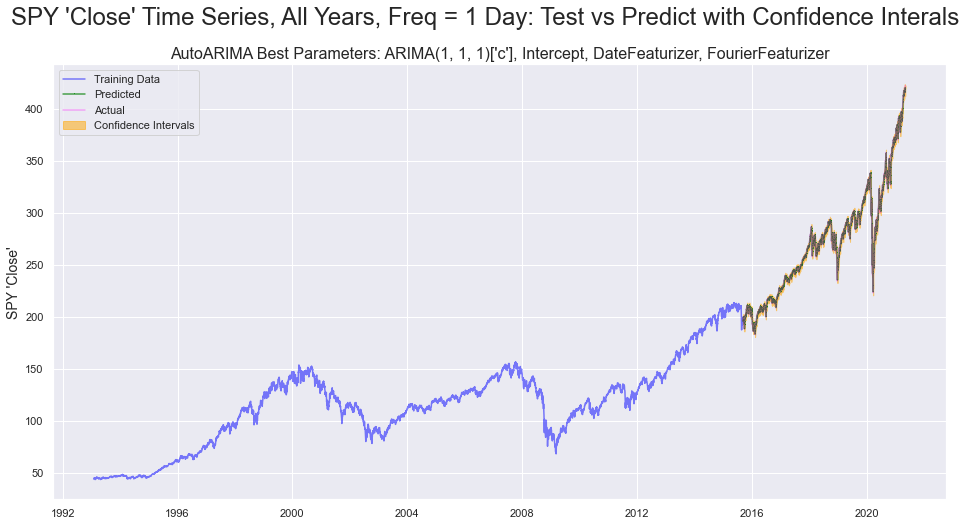

In [156]:
AIC, RMSE, RMSE_pc, SMAPE = pam_all_close.run_stepwise_CV(dynamic=False, verbose=1, visualize=True)

In [163]:
# Using an abbreviated set of params
pam_25Y_best, scores = pam_25Y_close.run_gridsearch_CV(max_order=6, max_d=7,
                                                 t_list=['c','t'], with_intercept=True,
                                                 date=True, fourier=True, box=False, log=False,
                                                 verbose=1, debug=True, parallel=False)

Starting GridSearchCV...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 5)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(0, 1, 5)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 1, 0)['t'], Intercept, D

ARIMA Order(1, 3, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 5)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(1, 3, 5)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 3, 1)['t'], Intercept, DateFeaturizer, FourierFea

ARIMA Order(2, 5, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 2)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 3)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 3)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 4)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(2, 5, 4)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
ARIMA Order(3, 5, 2)['t'], Intercept, DateFeaturizer, FourierFea

________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 
>_
Done.
AIC: 26591.364 | RMSE: 3.331 | SMAPE 0.703%
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=26591.364 | RMSE=3.331 | SMAPE=0.703%
First viable model found, RMSE=3.331
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 27932.731 | RMSE: 3.330 | SMAPE 0.703%
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=27932.731 | RMSE=3.330 | SMAPE=0.703%
Next best model found, RMSE=3.330
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 26497.022 | RMSE: 3.297 | SMAPE 0.698%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=26497.022 | RMSE=3.297 | SMAPE=0.698%
Next best model found, RMSE=3.297
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


>_
Done.
AIC: 27426.357 | RMSE: 3.302 | SMAPE 0.699%
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=27426.357 | RMSE=3.302 | SMAPE=0.699%
________________________________________________________________________

Starting step-wise cross-validation...
ARIMA Order(0, 1, 2)['c'], Intercept, DateFeaturizer, FourierFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=5, m=252)),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='c'))])
Iteratively making predictions on SPY 'Close' Time Series and updating model, beginning with first index of y_test ...


> 


KeyboardInterrupt: 

# Modeling with all variables

## Checking Fourier frequency

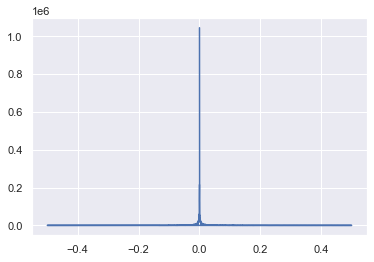

In [33]:
data = df_all_close
spectrum = np.fft.fft(data)
freq = np.fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

In [36]:
spectrum

array([1044572.23924255     +0.j        ,
        117653.69947317+180443.17984818j,
          9568.18963434+188362.6756979j , ...,
        -14685.85711616-130178.92039849j,
          9568.18963434-188362.6756979j ,
        117653.69947317-180443.17984818j])

In [41]:
freqs = list(zip(freq, spectrum))

In [47]:
freqs.sort(key = lambda x: x[1], reverse=True)

In [53]:
freq

array([ 0.        ,  0.00014045,  0.0002809 , ..., -0.00042135,
       -0.0002809 , -0.00014045])

In [52]:
freqs

[(0.0, (1044572.2392425537+0j)),
 (0.0001404494382022472, (117653.69947317209+180443.17984818298j)),
 (-0.0001404494382022472, (117653.69947317206-180443.17984818292j)),
 (0.0005617977528089888, (61638.48833579324+101672.68917113938j)),
 (-0.0005617977528089888, (61638.48833579323-101672.68917113937j)),
 (-0.0011235955056179776, (29108.889066894397-26911.199486687667j)),
 (0.0011235955056179776, (29108.889066894393+26911.19948668767j)),
 (0.001404494382022472, (11022.93805786431+33785.61683353728j)),
 (-0.001404494382022472, (11022.93805786431-33785.61683353727j)),
 (0.0002808988764044944, (9568.189634337148+188362.6756979j)),
 (-0.0002808988764044944, (9568.189634337148-188362.6756979j)),
 (0.0018258426966292136, (9156.974771633064+27985.21656702269j)),
 (-0.0018258426966292136, (9156.974771633064-27985.216567022686j)),
 (0.0021067415730337082, (8411.099799311905+30152.99288733887j)),
 (-0.0021067415730337082, (8411.099799311905-30152.992887338864j)),
 (-0.0025280898876404497, (7845.7

In [55]:
1/freqs[3][0]

1779.9999999999998

In [56]:
7120/252

28.253968253968253

In [39]:
periods = [1/f for f in freq if f != 0]
periods

[7119.999999999999,
 3559.9999999999995,
 2373.3333333333335,
 1779.9999999999998,
 1423.9999999999998,
 1186.6666666666667,
 1017.1428571428571,
 889.9999999999999,
 791.111111111111,
 711.9999999999999,
 647.2727272727271,
 593.3333333333334,
 547.6923076923076,
 508.57142857142856,
 474.6666666666666,
 444.99999999999994,
 418.8235294117647,
 395.5555555555555,
 374.7368421052631,
 355.99999999999994,
 339.04761904761904,
 323.63636363636357,
 309.5652173913043,
 296.6666666666667,
 284.79999999999995,
 273.8461538461538,
 263.7037037037037,
 254.28571428571428,
 245.51724137931035,
 237.3333333333333,
 229.6774193548387,
 222.49999999999997,
 215.75757575757575,
 209.41176470588235,
 203.4285714285714,
 197.77777777777774,
 192.43243243243242,
 187.36842105263156,
 182.56410256410254,
 177.99999999999997,
 173.65853658536585,
 169.52380952380952,
 165.5813953488372,
 161.81818181818178,
 158.2222222222222,
 154.78260869565216,
 151.48936170212764,
 148.33333333333334,
 145.30612244

In [532]:
debug = True
verbose = 1

## Get `is_option_expiry`

In [ ]:
opt_exp_3Y_df = create_option_expiry_df(date_index=spy_df_3Y.index, func='historical', freq=CBD)
opt_exp_5Y_df = create_option_expiry_df(date_index=spy_df_5Y.index, func='historical', freq=CBD)
opt_exp_10Y_df = create_option_expiry_df(date_index=spy_df_10Y.index, func='historical', freq=CBD)
opt_exp_all_df = create_option_expiry_df(date_index=spy_df_all.index, func='historical', freq=CBD)
opt_exp_fc_df = create_option_expiry_df(N=52, func='forecast', freq=CBD)

## Generate and run all models

Pmdarima_Model.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data..
Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['n'], DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added

________________________________________________________________________

Running step-wise cross-validation on model 1 of 16... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 25140.310 | RMSE: 60.640 | RMSE%=30.197% | SMAPE 19.027%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=25140.310 | RMSE=60.640 | RMSE_pc=30.197% | SMAPE=19.027%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=60.640
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 16... 
ARIMA Order(0, 

> 

Done.
AIC: 18668.308 | RMSE: 18.662 | RMSE%=9.293% | SMAPE 4.312%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=18668.308 | RMSE=18.662 | RMSE_pc=9.293% | SMAPE=4.312%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=18.662
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 16... 
ARIMA Order(0, 0, 1)

> 

Done.
AIC: 18646.890 | RMSE: 18.508 | RMSE%=9.216% | SMAPE 4.282%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=18646.890 | RMSE=18.508 | RMSE_pc=9.216% | SMAPE=4.282%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=18.508
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 16... 
ARIMA Order(0, 0, 1

> 

Done.
AIC: 25138.434 | RMSE: 60.732 | RMSE%=30.243% | SMAPE 19.059%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer]: AIC=25138.434 | RMSE=60.732 | RMSE_pc=30.243% | SMAPE=19.059%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 16... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 12021.358 | RMSE: 4.658 | RMSE%=2.319% | SMAPE 0.981%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=12021.358 | RMSE=4.658 | RMSE_pc=2.319% | SMAPE=0.981%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.658
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model outperforms existing best GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, overwriting.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 16... 
ARIMA Order(1, 0, 0)['t'], Inter

> 

Done.
AIC: 12013.557 | RMSE: 4.650 | RMSE%=2.316% | SMAPE 0.976%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=12013.557 | RMSE=4.650 | RMSE_pc=2.316% | SMAPE=0.976%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.650
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 16... 
ARIMA Order(1, 0, 0)['c

> 

Done.
AIC: 12015.789 | RMSE: 4.670 | RMSE%=2.326% | SMAPE 0.992%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=12015.789 | RMSE=4.670 | RMSE_pc=2.326% | SMAPE=0.992%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 16... 
ARIMA Order(1, 0, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 12019.872 | RMSE: 4.658 | RMSE%=2.320% | SMAPE 0.981%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer]: AIC=12019.872 | RMSE=4.658 | RMSE_pc=2.320% | SMAPE=0.981%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 16... 
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11951.304 | RMSE: 4.599 | RMSE%=2.290% | SMAPE 0.965%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11951.304 | RMSE=4.599 | RMSE_pc=2.290% | SMAPE=0.965%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.599
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 16... 
ARIMA Order(0, 1, 1)['

> 

Done.
AIC: 11958.345 | RMSE: 4.627 | RMSE%=2.304% | SMAPE 0.965%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11958.345 | RMSE=4.627 | RMSE_pc=2.304% | SMAPE=0.965%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 16... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11951.725 | RMSE: 4.606 | RMSE%=2.293% | SMAPE 0.962%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11951.725 | RMSE=4.606 | RMSE_pc=2.293% | SMAPE=0.962%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 19.
Adding scores to model, updating line 19.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 16... 
ARIMA Order(0, 1, 1)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11955.717 | RMSE: 4.604 | RMSE%=2.293% | SMAPE 0.969%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer]: AIC=11955.717 | RMSE=4.604 | RMSE_pc=2.293% | SMAPE=0.969%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 20.
Adding scores to model, updating line 20.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 16... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11939.924 | RMSE: 4.587 | RMSE%=2.284% | SMAPE 0.962%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11939.924 | RMSE=4.587 | RMSE_pc=2.284% | SMAPE=0.962%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.587
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 21.
Adding scores to model, updating line 21.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 16... 
ARIMA Order(1, 1, 0)['

> 

Done.
AIC: 11937.610 | RMSE: 4.611 | RMSE%=2.296% | SMAPE 0.963%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11937.610 | RMSE=4.611 | RMSE_pc=2.296% | SMAPE=0.963%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 22.
Adding scores to model, updating line 22.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 16... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11940.367 | RMSE: 4.633 | RMSE%=2.307% | SMAPE 0.968%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11940.367 | RMSE=4.633 | RMSE_pc=2.307% | SMAPE=0.968%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 23.
Adding scores to model, updating line 23.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 16... 
ARIMA Order(1, 1, 0)['n'], DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making in-sample predictions on 'SPY 'Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11944.459 | RMSE: 4.593 | RMSE%=2.287% | SMAPE 0.967%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer]: AIC=11944.459 | RMSE=4.593 | RMSE_pc=2.287% | SMAPE=0.967%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 24.
Adding scores to model, updating line 24.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11939.924 | RMSE=4.587 | RMSE%=2.284% | SMAPE=0.962%
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer]: AIC=11944.459 | RMSE=4.593 | RMSE%=2.287% | SMAPE=0.967%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11951.304 | RMSE=4.599 | RMSE%=2.290% | SMAPE=0.965%
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer]: AIC=11955.717 | RMSE=4.604 | RMSE%=2.293% | SMAPE=0.969%
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11951.725 | RMSE=4.606 | RMSE%=2.293% | SMAPE=0.962%
Model[ARIMA Order(1

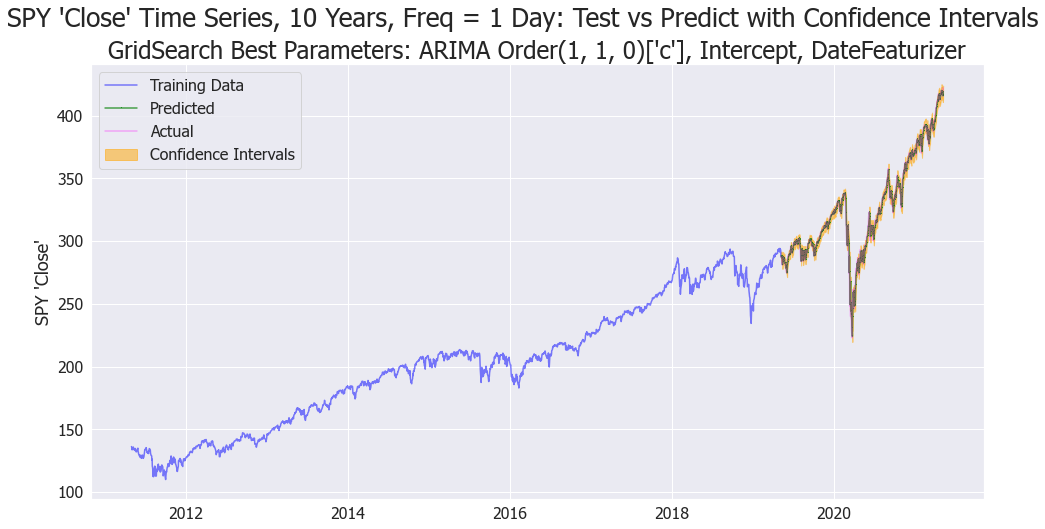

In [540]:
pam_10Y_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
# pam_10Y_close_auto = pam_10Y_close.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_close.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_close_best, scores = pam_10Y_close.run_gridsearch_CV(min_order=1, max_order=1, min_d=0, max_d=1, min_p=0, max_p=10, min_q=0, max_q=10,
                            with_intercept='auto', f_m=252, k=2, # t_list=['c','t'],
                            date=True, fourier=False, box=False, log=False,
                            verbose=verbose, debug=debug, parallel=False)

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7950.848, Time=6.10 sec
First viable model found (7950.848)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7970.196, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7967.967, Time=2.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7967.952, Time=1.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7972.038, Time=2.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7971.952, Time=2.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7969.961, Time=4.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7952.352, Time=7.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7952.

> 

Done.
Test AIC: 11677.982
Test RMSE: 4.249
This is 2.116% of the avg observed value.
Test SMAPE: 0.927%

Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_AA_best_model.pkl.

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to ad

________________________________________________________________________

Running step-wise cross-validation on model 1 of 18... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 28537.045 | RMSE: 119.375 | RMSE%=59.453% | SMAPE 41.650%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=28537.045 | RMSE=119.375 | RMSE_pc=59.453% | SMAPE=41.650%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 18... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21684.180 | RMSE: 34.052 | RMSE%=16.959% | SMAPE 7.919%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=21684.180 | RMSE=34.052 | RMSE_pc=16.959% | SMAPE=7.919%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 18... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21659.489 | RMSE: 33.823 | RMSE%=16.845% | SMAPE 7.875%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=21659.489 | RMSE=33.823 | RMSE_pc=16.845% | SMAPE=7.875%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 18... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 25160.337 | RMSE: 61.020 | RMSE%=30.390% | SMAPE 19.063%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=25160.337 | RMSE=61.020 | RMSE_pc=30.390% | SMAPE=19.063%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 18... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18664.293 | RMSE: 18.605 | RMSE%=9.266% | SMAPE 4.291%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=18664.293 | RMSE=18.605 | RMSE_pc=9.266% | SMAPE=4.291%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 18... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18635.952 | RMSE: 18.429 | RMSE%=9.178% | SMAPE 4.259%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=18635.952 | RMSE=18.429 | RMSE_pc=9.178% | SMAPE=4.259%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 18... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11717.871 | RMSE: 4.251 | RMSE%=2.117% | SMAPE 0.933%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=11717.871 | RMSE=4.251 | RMSE_pc=2.117% | SMAPE=0.933%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 18... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11709.870 | RMSE: 4.249 | RMSE%=2.116% | SMAPE 0.929%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=11709.870 | RMSE=4.249 | RMSE_pc=2.116% | SMAPE=0.929%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 18... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11718.839 | RMSE: 4.271 | RMSE%=2.127% | SMAPE 0.940%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=11718.839 | RMSE=4.271 | RMSE_pc=2.127% | SMAPE=0.940%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 18... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11698.182 | RMSE: 4.246 | RMSE%=2.115% | SMAPE 0.927%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11698.182 | RMSE=4.246 | RMSE_pc=2.115% | SMAPE=0.927%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=4.246
Saved best GridSearchCV model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 18... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
               

> 

Done.
AIC: 11696.594 | RMSE: 4.245 | RMSE%=2.114% | SMAPE 0.924%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11696.594 | RMSE=4.245 | RMSE_pc=2.114% | SMAPE=0.924%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.245
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 18... 
ARIMA Order(0, 1, 0)['ct

> 

Done.
AIC: 11734.022 | RMSE: 4.242 | RMSE%=2.113% | SMAPE 0.925%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11734.022 | RMSE=4.242 | RMSE_pc=2.113% | SMAPE=0.925%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.242
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 18... 
ARIMA Order(0, 1, 1)['c

> 

Done.
AIC: 11688.795 | RMSE: 4.242 | RMSE%=2.113% | SMAPE 0.923%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11688.795 | RMSE=4.242 | RMSE_pc=2.113% | SMAPE=0.923%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.242
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 18... 
ARIMA Order(0, 1, 1)['t'

> 

Done.
AIC: 11696.116 | RMSE: 4.233 | RMSE%=2.108% | SMAPE 0.919%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11696.116 | RMSE=4.233 | RMSE_pc=2.108% | SMAPE=0.919%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.233
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 18... 
ARIMA Order(0, 1, 1)['ct

> 

Done.
AIC: 11690.121 | RMSE: 4.234 | RMSE%=2.108% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11690.121 | RMSE=4.234 | RMSE_pc=2.108% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 18... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11688.211 | RMSE: 4.241 | RMSE%=2.112% | SMAPE 0.923%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11688.211 | RMSE=4.241 | RMSE_pc=2.112% | SMAPE=0.923%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 17 of 18... 
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11687.187 | RMSE: 4.238 | RMSE%=2.111% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.187 | RMSE=4.238 | RMSE_pc=2.111% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 18 of 18... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Open'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11688.632 | RMSE: 4.235 | RMSE%=2.109% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11688.632 | RMSE=4.235 | RMSE_pc=2.109% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11696.116 | RMSE=4.233 | RMSE%=2.108% | SMAPE=0.919%
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11690.121 | RMSE=4.234 | RMSE%=2.108% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11688.632 | RMSE=4.235 | RMSE%=2.109% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.187 | RMSE=4.238 | RMSE%=2.111% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11688.211 | RMSE=4.241 | RMSE%=2.112%

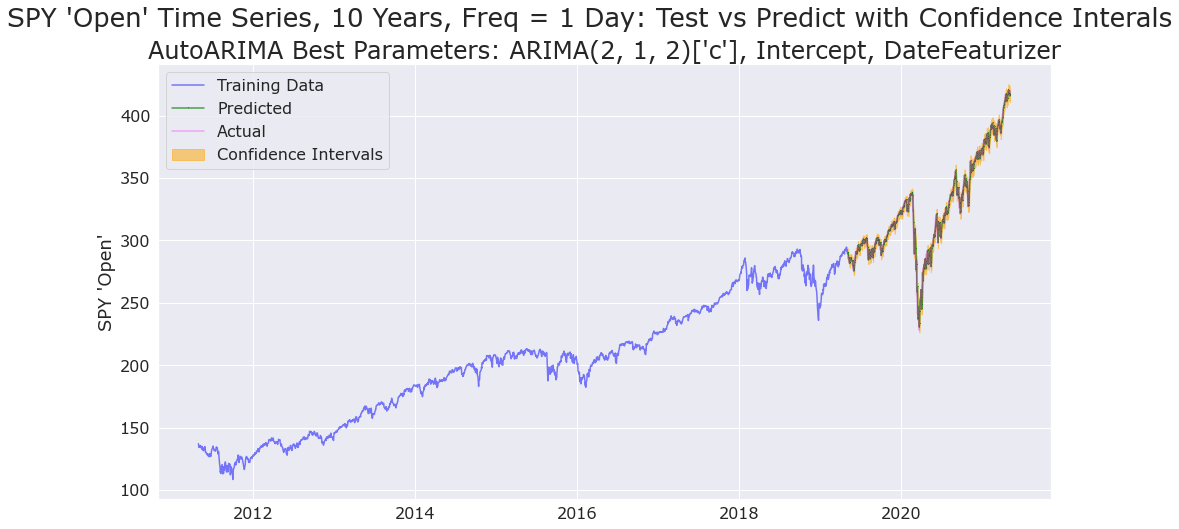

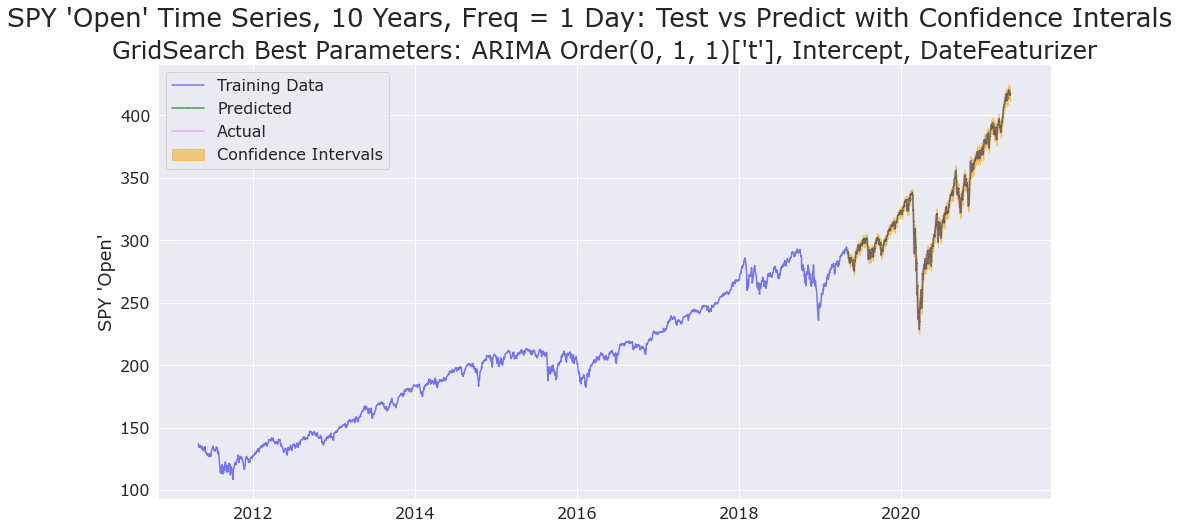

In [526]:
pam_10Y_open = Pmdarima_Model(df_10Y_open, 'SPY \'Open\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
# pam_10Y_open_auto = pam_10Y_open.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_open.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_open_best, scores = pam_10Y_open.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, #f_m=252, k=2,
                            date=True, fourier=False, box=False, log=False,
                            verbose=verbose, debug=debug, parallel=False)

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7152.835, Time=20.99 sec
First viable model found (7152.835)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7159.930, Time=1.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7151.194, Time=1.36 sec
New best model found (7151.194 < 7152.835)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7151.428, Time=1.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7163.706, Time=1.78 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7153.098, Time=1.70 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7153.136, Time=1.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7147.006, Time=7.57 sec
New

> 

Done.
Test AIC: 10713.724
Test RMSE: 3.524
This is 1.747% of the avg observed value.
Test SMAPE: 0.751%

/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_AA_best_model.pkl
Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_AA_best_model.pkl.

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already pre

________________________________________________________________________

Running step-wise cross-validation on model 1 of 18... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 28563.245 | RMSE: 120.247 | RMSE%=59.615% | SMAPE 41.838%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=28563.245 | RMSE=120.247 | RMSE_pc=59.615% | SMAPE=41.838%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 18... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21625.119 | RMSE: 33.655 | RMSE%=16.685% | SMAPE 7.758%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=21625.119 | RMSE=33.655 | RMSE_pc=16.685% | SMAPE=7.758%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 18... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21599.197 | RMSE: 33.468 | RMSE%=16.593% | SMAPE 7.725%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=21599.197 | RMSE=33.468 | RMSE_pc=16.593% | SMAPE=7.725%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 18... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 25168.311 | RMSE: 61.198 | RMSE%=30.340% | SMAPE 19.114%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=25168.311 | RMSE=61.198 | RMSE_pc=30.340% | SMAPE=19.114%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 18... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18518.748 | RMSE: 18.112 | RMSE%=8.979% | SMAPE 4.101%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=18518.748 | RMSE=18.112 | RMSE_pc=8.979% | SMAPE=4.101%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 18... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18486.939 | RMSE: 17.906 | RMSE%=8.877% | SMAPE 4.065%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=18486.939 | RMSE=17.906 | RMSE_pc=8.877% | SMAPE=4.065%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 18... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10739.573 | RMSE: 3.515 | RMSE%=1.742% | SMAPE 0.748%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=10739.573 | RMSE=3.515 | RMSE_pc=1.742% | SMAPE=0.748%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=3.515
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl
Saved best GridSearchCV model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 18... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer

> 

Done.
AIC: 10733.602 | RMSE: 3.510 | RMSE%=1.740% | SMAPE 0.746%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=10733.602 | RMSE=3.510 | RMSE_pc=1.740% | SMAPE=0.746%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=3.510
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 18... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturize

> 

Done.
AIC: 10740.056 | RMSE: 3.530 | RMSE%=1.750% | SMAPE 0.757%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=10740.056 | RMSE=3.530 | RMSE_pc=1.750% | SMAPE=0.757%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 18... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10716.798 | RMSE: 3.509 | RMSE%=1.740% | SMAPE 0.745%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=10716.798 | RMSE=3.509 | RMSE_pc=1.740% | SMAPE=0.745%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=3.509
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 18... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturi

> 

Done.
AIC: 10714.718 | RMSE: 3.502 | RMSE%=1.736% | SMAPE 0.743%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=10714.718 | RMSE=3.502 | RMSE_pc=1.736% | SMAPE=0.743%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=3.502
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 18... 
ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeatur

> 

Done.
AIC: 10759.547 | RMSE: 3.507 | RMSE%=1.739% | SMAPE 0.744%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=10759.547 | RMSE=3.507 | RMSE_pc=1.739% | SMAPE=0.744%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 18... 
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10709.738 | RMSE: 3.515 | RMSE%=1.743% | SMAPE 0.749%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=10709.738 | RMSE=3.515 | RMSE_pc=1.743% | SMAPE=0.749%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 18... 
ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10707.708 | RMSE: 3.510 | RMSE%=1.740% | SMAPE 0.747%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=10707.708 | RMSE=3.510 | RMSE_pc=1.740% | SMAPE=0.747%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 18... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10779.804 | RMSE: 3.507 | RMSE%=1.738% | SMAPE 0.747%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=10779.804 | RMSE=3.507 | RMSE_pc=1.738% | SMAPE=0.747%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 18... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10709.145 | RMSE: 3.515 | RMSE%=1.743% | SMAPE 0.749%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=10709.145 | RMSE=3.515 | RMSE_pc=1.743% | SMAPE=0.749%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 17 of 18... 
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10709.937 | RMSE: 3.508 | RMSE%=1.739% | SMAPE 0.747%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=10709.937 | RMSE=3.508 | RMSE_pc=1.739% | SMAPE=0.747%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 18 of 18... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'High'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 10714.096 | RMSE: 3.502 | RMSE%=1.736% | SMAPE 0.747%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=10714.096 | RMSE=3.502 | RMSE_pc=1.736% | SMAPE=0.747%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=3.502
/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=10714.096 | RMSE=3.502 | RMSE%=1.736% | SMAPE=0.747%
Model

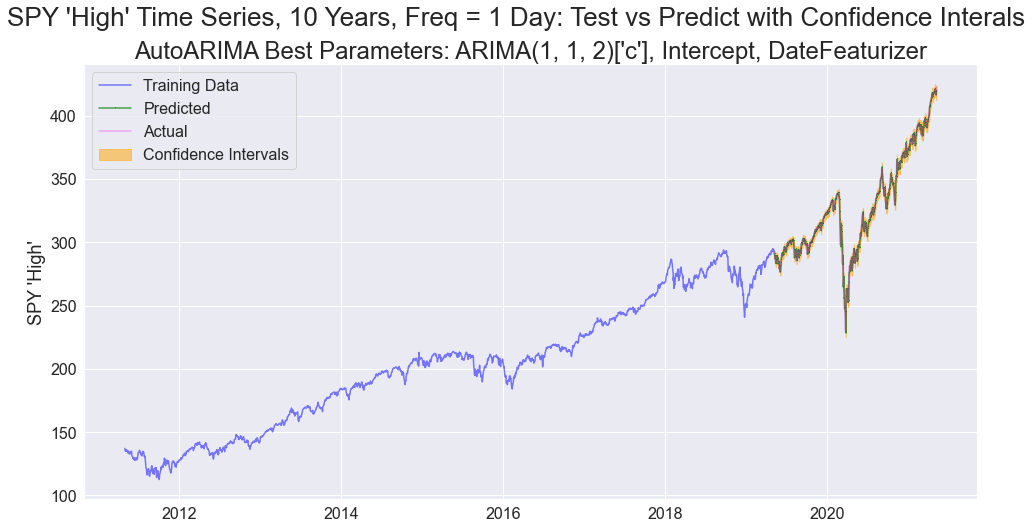

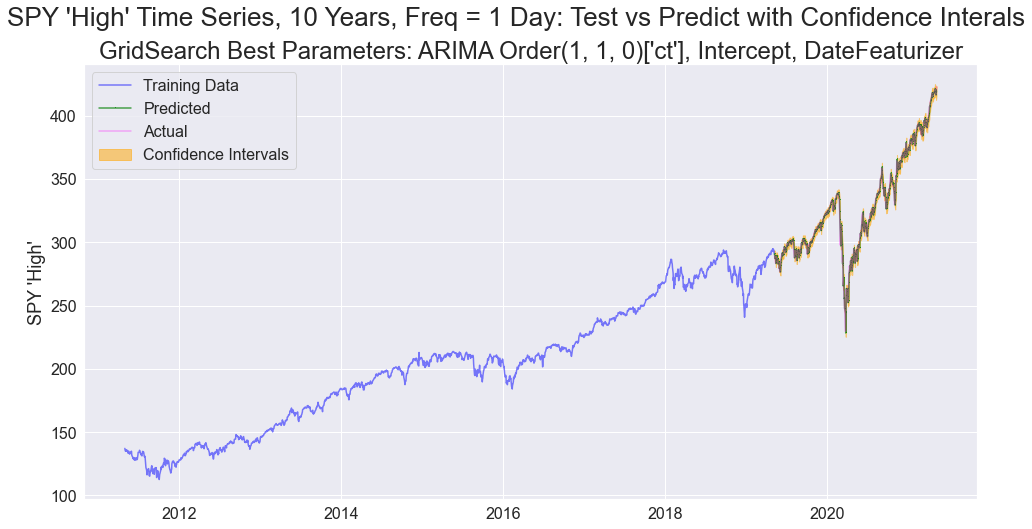

In [521]:
pam_10Y_high = Pmdarima_Model(df_10Y_high, 'SPY \'High\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
# pam_10Y_high_auto = pam_10Y_high.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_high.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_high_best, scores = pam_10Y_high.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, #f_m=252, k=2,
                            date=True, fourier=False, box=False, log=False,
                            verbose=verbose, debug=debug, parallel=False)

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7950.848, Time=8.20 sec
First viable model found (7950.848)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7970.196, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7967.967, Time=0.87 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7967.952, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7972.038, Time=1.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7971.952, Time=1.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7969.961, Time=3.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7952.352, Time=6.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7952.

> 

Done.
Test AIC: 11677.982
Test RMSE: 4.249
This is 2.116% of the avg observed value.
Test SMAPE: 0.927%

Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_AA_best_model.pkl.

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attempting to add

________________________________________________________________________

Running step-wise cross-validation on model 1 of 18... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 28537.045 | RMSE: 119.375 | RMSE%=59.453% | SMAPE 41.650%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=28537.045 | RMSE=119.375 | RMSE_pc=59.453% | SMAPE=41.650%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 18... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21684.180 | RMSE: 34.052 | RMSE%=16.959% | SMAPE 7.919%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=21684.180 | RMSE=34.052 | RMSE_pc=16.959% | SMAPE=7.919%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 18... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21659.489 | RMSE: 33.823 | RMSE%=16.845% | SMAPE 7.875%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=21659.489 | RMSE=33.823 | RMSE_pc=16.845% | SMAPE=7.875%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 18... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 25160.337 | RMSE: 61.020 | RMSE%=30.390% | SMAPE 19.063%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=25160.337 | RMSE=61.020 | RMSE_pc=30.390% | SMAPE=19.063%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 18... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18664.293 | RMSE: 18.605 | RMSE%=9.266% | SMAPE 4.291%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=18664.293 | RMSE=18.605 | RMSE_pc=9.266% | SMAPE=4.291%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 18... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18635.952 | RMSE: 18.429 | RMSE%=9.178% | SMAPE 4.259%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=18635.952 | RMSE=18.429 | RMSE_pc=9.178% | SMAPE=4.259%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 18... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11717.871 | RMSE: 4.251 | RMSE%=2.117% | SMAPE 0.933%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=11717.871 | RMSE=4.251 | RMSE_pc=2.117% | SMAPE=0.933%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 18... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11709.870 | RMSE: 4.249 | RMSE%=2.116% | SMAPE 0.929%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=11709.870 | RMSE=4.249 | RMSE_pc=2.116% | SMAPE=0.929%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 18... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11718.839 | RMSE: 4.271 | RMSE%=2.127% | SMAPE 0.940%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=11718.839 | RMSE=4.271 | RMSE_pc=2.127% | SMAPE=0.940%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 18... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11698.182 | RMSE: 4.246 | RMSE%=2.115% | SMAPE 0.927%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11698.182 | RMSE=4.246 | RMSE_pc=2.115% | SMAPE=0.927%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=4.246
Saved best GridSearchCV model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 18... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                

> 

Done.
AIC: 11696.594 | RMSE: 4.245 | RMSE%=2.114% | SMAPE 0.924%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11696.594 | RMSE=4.245 | RMSE_pc=2.114% | SMAPE=0.924%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.245
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 18... 
ARIMA Order(0, 1, 0)['ct']

> 

Done.
AIC: 11734.022 | RMSE: 4.242 | RMSE%=2.113% | SMAPE 0.925%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11734.022 | RMSE=4.242 | RMSE_pc=2.113% | SMAPE=0.925%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.242
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 18... 
ARIMA Order(0, 1, 1)['c']

> 

Done.
AIC: 11688.795 | RMSE: 4.242 | RMSE%=2.113% | SMAPE 0.923%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11688.795 | RMSE=4.242 | RMSE_pc=2.113% | SMAPE=0.923%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.242
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 18... 
ARIMA Order(0, 1, 1)['t'],

> 

Done.
AIC: 11696.116 | RMSE: 4.233 | RMSE%=2.108% | SMAPE 0.919%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11696.116 | RMSE=4.233 | RMSE_pc=2.108% | SMAPE=0.919%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.233
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 18... 
ARIMA Order(0, 1, 1)['ct']

> 

Done.
AIC: 11690.121 | RMSE: 4.234 | RMSE%=2.108% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11690.121 | RMSE=4.234 | RMSE_pc=2.108% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 18... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11688.211 | RMSE: 4.241 | RMSE%=2.112% | SMAPE 0.923%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11688.211 | RMSE=4.241 | RMSE_pc=2.112% | SMAPE=0.923%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 17 of 18... 
ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11687.187 | RMSE: 4.238 | RMSE%=2.111% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.187 | RMSE=4.238 | RMSE_pc=2.111% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 18 of 18... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Low'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11688.632 | RMSE: 4.235 | RMSE%=2.109% | SMAPE 0.920%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11688.632 | RMSE=4.235 | RMSE_pc=2.109% | SMAPE=0.920%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11696.116 | RMSE=4.233 | RMSE%=2.108% | SMAPE=0.919%
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11690.121 | RMSE=4.234 | RMSE%=2.108% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11688.632 | RMSE=4.235 | RMSE%=2.109% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.187 | RMSE=4.238 | RMSE%=2.111% | SMAPE=0.920%
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11688.211 | RMSE=4.241 | RMSE%=2.112%

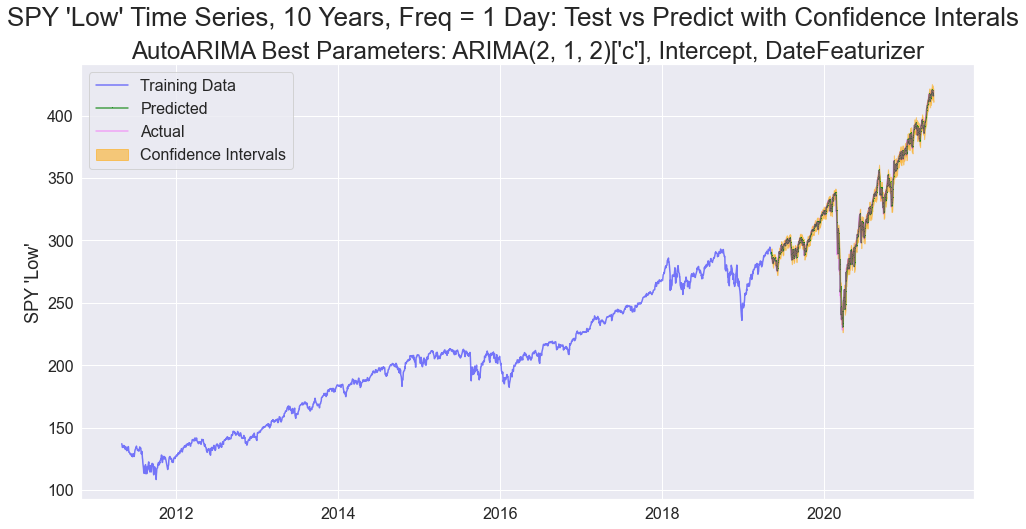

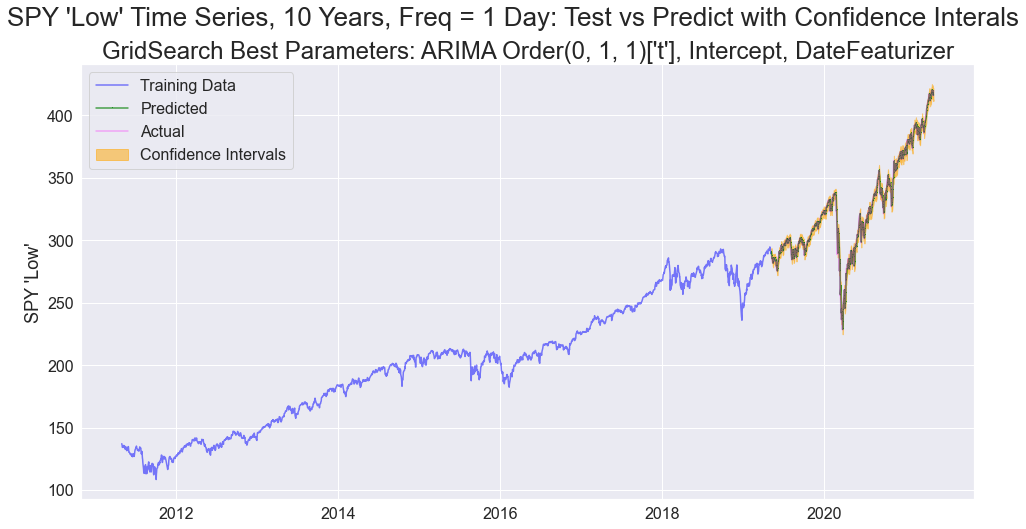

In [522]:
pam_10Y_low = Pmdarima_Model(df_10Y_low, 'SPY \'Low\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
# pam_10Y_low_auto = pam_10Y_low.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_low.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_low_best, scores = pam_10Y_low.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, #f_m=252, k=2,
                            date=True, fourier=False, box=False, log=False,
                            verbose=verbose, debug=debug, parallel=False)

[autoreload of functions failed: Traceback (most recent call last):
  File "/Users/wax/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/wax/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/wax/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/wax/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../code/functions

Successfully created instance of Class Pmdarima_Model.
Starting AutoARIMA...
Data set diffs to use: 1
Parameters for AutoARIMA Pipeline: 
  AutoARIMA, Check Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 AutoARIMA(d=1, maxiter=200, seasonal=False, trace=4))]) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7602.177, Time=9.64 sec
First viable model found (7602.177)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7603.419, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7604.572, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7604.535, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7606.830, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7600.244, Time=10.08 sec
New best model found (7600.244 < 7602.177)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7605.620, Time=0.89 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7598.372, Time=9.26 sec
New

> 

Done.
Test AIC: 11759.187
Test RMSE: 4.558
This is 2.517% of the avg observed value.
Test SMAPE: 0.977%

Saved best AutoARIMA model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_AA_best_model.pkl.

Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Attemp

________________________________________________________________________

Running step-wise cross-validation on model 1 of 18... 
ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 28977.328 | RMSE: 132.536 | RMSE%=73.184% | SMAPE 48.645%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=28977.328 | RMSE=132.536 | RMSE_pc=73.184% | SMAPE=48.645%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 1.
Adding scores to model, updating line 1.
________________________________________________________________________

Running step-wise cross-validation on model 2 of 18... 
ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21942.872 | RMSE: 37.296 | RMSE%=20.594% | SMAPE 9.080%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=21942.872 | RMSE=37.296 | RMSE_pc=20.594% | SMAPE=9.080%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 2.
Adding scores to model, updating line 2.
________________________________________________________________________

Running step-wise cross-validation on model 3 of 18... 
ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 21918.127 | RMSE: 37.007 | RMSE%=20.435% | SMAPE 9.021%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=21918.127 | RMSE=37.007 | RMSE_pc=20.435% | SMAPE=9.021%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 3.
Adding scores to model, updating line 3.
________________________________________________________________________

Running step-wise cross-validation on model 4 of 18... 
ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 25562.774 | RMSE: 67.113 | RMSE%=37.059% | SMAPE 21.819%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['c'], Intercept, DateFeaturizer]: AIC=25562.774 | RMSE=67.113 | RMSE_pc=37.059% | SMAPE=21.819%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 4.
Adding scores to model, updating line 4.
________________________________________________________________________

Running step-wise cross-validation on model 5 of 18... 
ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18880.308 | RMSE: 20.255 | RMSE%=11.185% | SMAPE 4.851%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['t'], Intercept, DateFeaturizer]: AIC=18880.308 | RMSE=20.255 | RMSE_pc=11.185% | SMAPE=4.851%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 5.
Adding scores to model, updating line 5.
________________________________________________________________________

Running step-wise cross-validation on model 6 of 18... 
ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 18848.021 | RMSE: 20.013 | RMSE%=11.051% | SMAPE 4.799%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['ct'], Intercept, DateFeaturizer]: AIC=18848.021 | RMSE=20.013 | RMSE_pc=11.051% | SMAPE=4.799%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 6.
Adding scores to model, updating line 6.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 18... 
ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11780.203 | RMSE: 4.563 | RMSE%=2.519% | SMAPE 0.974%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['c'], Intercept, DateFeaturizer]: AIC=11780.203 | RMSE=4.563 | RMSE_pc=2.519% | SMAPE=0.974%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 7.
Adding scores to model, updating line 7.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 18... 
ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='t'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11771.110 | RMSE: 4.558 | RMSE%=2.517% | SMAPE 0.971%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['t'], Intercept, DateFeaturizer]: AIC=11771.110 | RMSE=4.558 | RMSE_pc=2.517% | SMAPE=0.971%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 8.
Adding scores to model, updating line 8.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 18... 
ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 0, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11781.052 | RMSE: 4.590 | RMSE%=2.535% | SMAPE 0.992%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['ct'], Intercept, DateFeaturizer]: AIC=11781.052 | RMSE=4.590 | RMSE_pc=2.535% | SMAPE=0.992%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 9.
Adding scores to model, updating line 9.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 18... 
ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11759.077 | RMSE: 4.558 | RMSE%=2.517% | SMAPE 0.970%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11759.077 | RMSE=4.558 | RMSE_pc=2.517% | SMAPE=0.970%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=4.558
Saved best GridSearchCV model as /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 10.
Adding scores to model, updating line 10.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 18... 
ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
     

> 

Done.
AIC: 11757.532 | RMSE: 4.553 | RMSE%=2.514% | SMAPE 0.967%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11757.532 | RMSE=4.553 | RMSE_pc=2.514% | SMAPE=0.967%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.553
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 11.
Adding scores to model, updating line 11.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 18... 
ARIM

> 

Done.
AIC: 11759.779 | RMSE: 4.555 | RMSE%=2.515% | SMAPE 0.969%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11759.779 | RMSE=4.555 | RMSE_pc=2.515% | SMAPE=0.969%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 12.
Adding scores to model, updating line 12.
________________________________________________________________________

Running step-wise cross-validation on model 13 of 18... 
ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11702.722 | RMSE: 4.503 | RMSE%=2.487% | SMAPE 0.958%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11702.722 | RMSE=4.503 | RMSE_pc=2.487% | SMAPE=0.958%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.503
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 13.
Adding scores to model, updating line 13.
________________________________________________________________________

Running step-wise cross-validation on model 14 of 18... 
ARIM

> 

Done.
AIC: 11708.761 | RMSE: 4.522 | RMSE%=2.497% | SMAPE 0.956%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11708.761 | RMSE=4.522 | RMSE_pc=2.497% | SMAPE=0.956%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 14.
Adding scores to model, updating line 14.
________________________________________________________________________

Running step-wise cross-validation on model 15 of 18... 
ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11707.013 | RMSE: 4.529 | RMSE%=2.501% | SMAPE 0.960%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['ct'], Intercept, DateFeaturizer]: AIC=11707.013 | RMSE=4.529 | RMSE_pc=2.501% | SMAPE=0.960%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 15.
Adding scores to model, updating line 15.
________________________________________________________________________

Running step-wise cross-validation on model 16 of 18... 
ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='c'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11689.332 | RMSE: 4.491 | RMSE%=2.480% | SMAPE 0.956%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11689.332 | RMSE=4.491 | RMSE_pc=2.480% | SMAPE=0.956%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=4.491
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 16.
Adding scores to model, updating line 16.
________________________________________________________________________

Running step-wise cross-validation on model 17 of 18... 
ARIM

> 

Done.
AIC: 11687.301 | RMSE: 4.502 | RMSE%=2.486% | SMAPE 0.955%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.301 | RMSE=4.502 | RMSE_pc=2.486% | SMAPE=0.955%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 17.
Adding scores to model, updating line 17.
________________________________________________________________________

Running step-wise cross-validation on model 18 of 18... 
ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='ct'))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Adjusted Close'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 11690.195 | RMSE: 4.503 | RMSE%=2.486% | SMAPE 0.956%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11690.195 | RMSE=4.503 | RMSE_pc=2.486% | SMAPE=0.956%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 18.
Adding scores to model, updating line 18.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer]: AIC=11689.332 | RMSE=4.491 | RMSE%=2.480% | SMAPE=0.956%
Model[ARIMA Order(1, 1, 0)['t'], Intercept, DateFeaturizer]: AIC=11687.301 | RMSE=4.502 | RMSE%=2.486% | SMAPE=0.955%
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer]: AIC=11690.195 | RMSE=4.503 | RMSE%=2.486% | SMAPE=0.956%
Model[ARIMA Order(0, 1, 1)['c'], Intercept, DateFeaturizer]: AIC=11702.722 | RMSE=4.503 | RMSE%=2.487% | SMAPE=0.958%
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer]: AIC=11708.761 | RMSE=4.522 | RMSE%=2.497% 

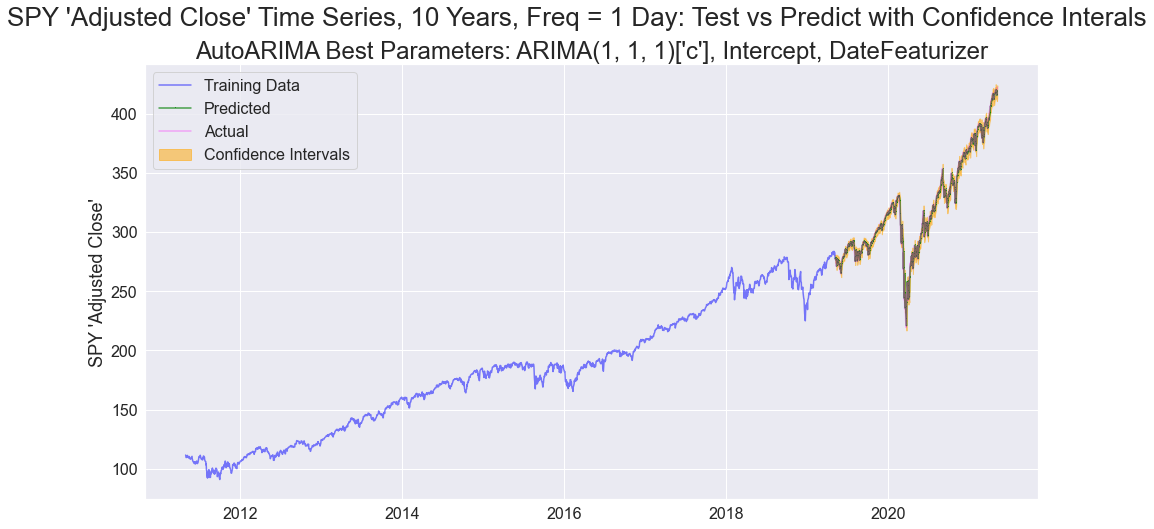

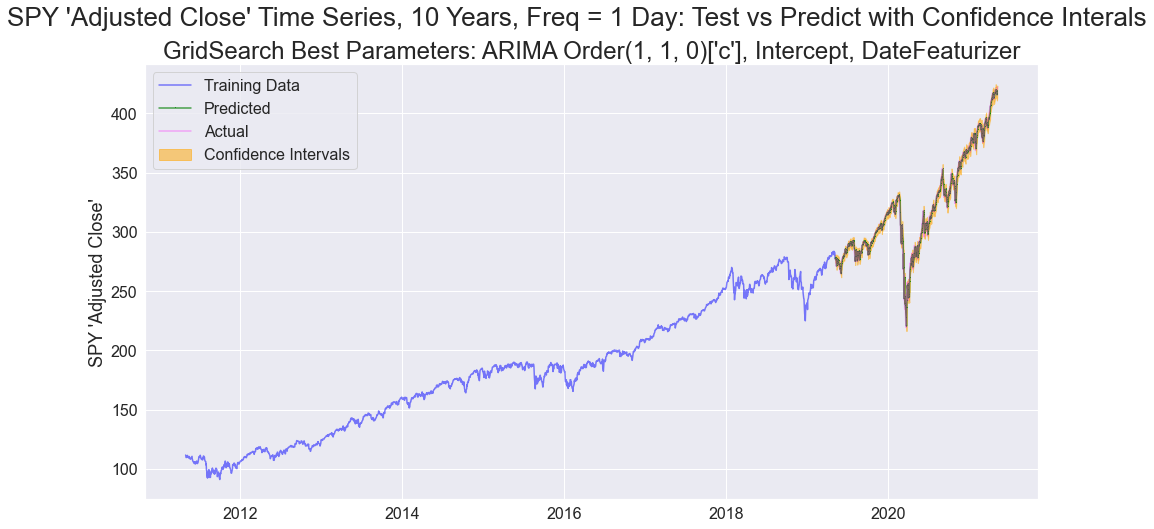

In [523]:
pam_10Y_a_close = Pmdarima_Model(df_10Y_a_close, 'SPY \'Adjusted Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=False)
# pam_10Y_a_close_auto = pam_10Y_a_close.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_a_close.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_a_close_best, scores = pam_10Y_a_close.run_gridsearch_CV(max_order=1, max_d=1,
                            t_list=['c', 't', 'ct'], with_intercept=True, #f_m=252, k=2,
                            date=True, fourier=False, box=False, log=False,
                            verbose=verbose, debug=debug, parallel=False)

Successfully created instance of Class Pmdarima_Model.
Setting up GridSearchCV...
Building list of models to test.
ARIMA Order(0, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(0, 0, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to test grid.
ARIMA Order(1, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Attempting to add new model params to file... Model not already present in file. Appending model params to file. 
Added a model to 

________________________________________________________________________

Running step-wise cross-validation on model 1 of 12... 
ARIMA Order(0, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 0, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making predictions on 'SPY 'Volume'' Time Series and updating model, beginning with first index of y_test ...


> 

Done.
AIC: 3607.577 | RMSE: 57709492.762 | RMSE%=48.057% | SMAPE 46.825%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=3607.577 | RMSE=57709492.762 | RMSE_pc=48.057% | SMAPE=46.825%
Updated class attributes for GridSearch performance.
First viable model found, RMSE=57709492.762
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 33.
Adding scores to model, updating line 33.
________________________________________________________________________

Running step-wise cros

> 

Done.
AIC: 2333.816 | RMSE: 44305544.335 | RMSE%=36.895% | SMAPE 36.073%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=2333.816 | RMSE=44305544.335 | RMSE_pc=36.895% | SMAPE=36.073%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=44305544.335
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 34.
Adding scores to model, updating line 34.
________________________________________________________________________

Running step-wise cross-v

> 

Done.
AIC: 1834.580 | RMSE: 39216481.062 | RMSE%=32.657% | SMAPE 31.891%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 0, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=1834.580 | RMSE=39216481.062 | RMSE_pc=32.657% | SMAPE=31.891%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=39216481.062
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 35.
Adding scores to model, updating line 35.
________________________________________________________________________

Running step-wise cross-v

> 

Done.
AIC: 1152.703 | RMSE: 32030351.544 | RMSE%=26.673% | SMAPE 26.394%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=1152.703 | RMSE=32030351.544 | RMSE_pc=26.673% | SMAPE=26.394%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=32030351.544
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 36.
Adding scores to model, updating line 36.
________________________________________________________________________

Running step-wise cross-v

> 

Done.
AIC: 849.938 | RMSE: 29849058.918 | RMSE%=24.857% | SMAPE 24.823%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 0, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=849.938 | RMSE=29849058.918 | RMSE_pc=24.857% | SMAPE=24.823%
Updated class attributes for GridSearch performance.
Next best model found, RMSE=29849058.918
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.
Model did not outperform existing GridSearchCV model at /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl, not pickling model.
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 37.
Adding scores to model, updating line 37.
________________________________________________________________________

Running step-wise cross-val

> 

Done.
AIC: 945.121 | RMSE: 30369433.085 | RMSE%=25.290% | SMAPE 25.287%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=945.121 | RMSE=30369433.085 | RMSE_pc=25.290% | SMAPE=25.287%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 38.
Adding scores to model, updating line 38.
________________________________________________________________________

Running step-wise cross-validation on model 7 of 12... 
ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making pre

> 

Done.
AIC: 1430.649 | RMSE: 32961335.267 | RMSE%=27.448% | SMAPE 26.974%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=1430.649 | RMSE=32961335.267 | RMSE_pc=27.448% | SMAPE=26.974%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 39.
Adding scores to model, updating line 39.
________________________________________________________________________

Running step-wise cross-validation on model 8 of 12... 
ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making p

> 

Done.
AIC: 906.307 | RMSE: 30077561.981 | RMSE%=25.047% | SMAPE 24.701%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=906.307 | RMSE=30077561.981 | RMSE_pc=25.047% | SMAPE=24.701%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 40.
Adding scores to model, updating line 40.
________________________________________________________________________

Running step-wise cross-validation on model 9 of 12... 
ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(0, 1, 2), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making pre

> 

Done.
AIC: 859.082 | RMSE: 30626629.783 | RMSE%=25.504% | SMAPE 24.359%
Successfully completed step-wise CV on model.
Model[ARIMA Order(0, 1, 2)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=859.082 | RMSE=30626629.783 | RMSE_pc=25.504% | SMAPE=24.359%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 41.
Adding scores to model, updating line 41.
________________________________________________________________________

Running step-wise cross-validation on model 10 of 12... 
ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making pr

> 

Done.
AIC: 1086.691 | RMSE: 30645791.445 | RMSE%=25.520% | SMAPE 25.437%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=1086.691 | RMSE=30645791.445 | RMSE_pc=25.520% | SMAPE=25.437%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 42.
Adding scores to model, updating line 42.
________________________________________________________________________

Running step-wise cross-validation on model 11 of 12... 
ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(1, 1, 1), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making 

> 

Done.
AIC: 832.625 | RMSE: 31770442.590 | RMSE%=26.457% | SMAPE 24.287%
Successfully completed step-wise CV on model.
Model[ARIMA Order(1, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=832.625 | RMSE=31770442.590 | RMSE_pc=26.457% | SMAPE=24.287%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 43.
Adding scores to model, updating line 43.
________________________________________________________________________

Running step-wise cross-validation on model 12 of 12... 
ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer
Pipeline(steps=[('date', DateFeaturizer(column_name='date')),
                ('fourier', FourierFeaturizer(k=2, m=252)),
                ('log', LogEndogTransformer()),
                ('arima',
                 ARIMA(maxiter=200, order=(2, 1, 0), suppress_warnings=True,
                       trend='n', with_intercept=False))])
Running in debug mode.
Iteratively making pr

> 

Done.
AIC: 977.153 | RMSE: 30167474.286 | RMSE%=25.122% | SMAPE 25.114%
Successfully completed step-wise CV on model.
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=977.153 | RMSE=30167474.286 | RMSE_pc=25.122% | SMAPE=25.114%
Attempting to add a new score to file... Model found in file. Not yet scored. Index is 44.
Adding scores to model, updating line 44.

GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 0, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=849.938 | RMSE=29849058.918 | RMSE%=24.857% | SMAPE=24.823%
Model[ARIMA Order(0, 1, 1)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=906.307 | RMSE=30077561.981 | RMSE%=25.047% | SMAPE=24.701%
Model[ARIMA Order(2, 1, 0)['n'], DateFeaturizer, FourierFeaturizer, LogEndogTransformer]: AIC=977.153 | RMSE=30167474.286 | RMSE%=25.122% | SMAPE=25.114%
Model[ARIMA Order(2, 0, 0)['n'], DateFeaturizer, FourierFeaturizer, LogE

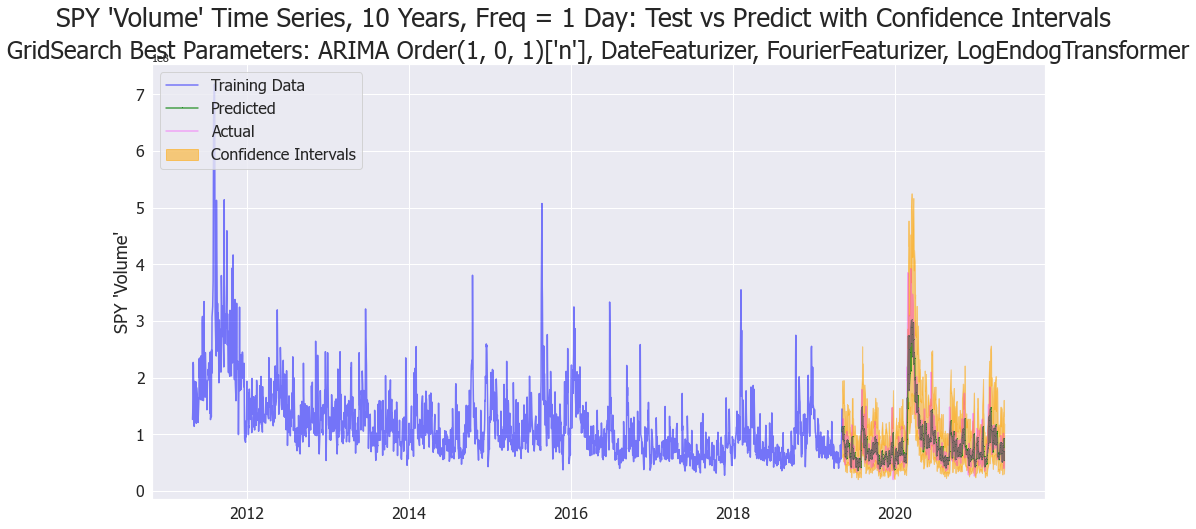

In [538]:
pam_10Y_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=verbose,
                            date=True, fourier=False, box=False, log=True)
# pam_10Y_vol_auto = pam_10Y_vol.run_auto_pipeline(show_summary=False, verbose=verbose, visualize=False)
# AA_CV_scores = pam_10Y_vol.run_stepwise_CV(dynamic=False, verbose=verbose, visualize=True)
pam_10Y_vol_best, scores = pam_10Y_vol.run_gridsearch_CV(min_order=0, max_order=2, min_d=0, max_d=1,
                            t_list=['n','c', 't', 'ct'], with_intercept=False, f_m=252, k=2,
                            date=True, fourier=True, box=False, log=True,
                            verbose=verbose, debug=debug, parallel=False)

In [ ]:
exog_10Y_fc_df = Pmdarima_Model.join_exog_data(new_dates_df,
                                            opt_exp_fc_df
                                            open_10Y_hat_df,
                                            high_10Y_hat_df,
                                            low_10Y_hat_df,
                                            a_close_10Y_hat_df
                                            vol_10Y_hat_df,
                                           )

In [ ]:
exog_10Y_hist_df = opt_exp_10Y_df.join(df_10Y_open).join(df_10Y_high).join(df_10Y_low).join(df_10Y_a_close).join(df_10Y_vol)
_hist_df.reset_index(inplace=True)
exog_10Y_hist_df

In [ ]:
open_10Y_hat_df, open_10Y_hat, new_dates_df, open_10Y_conf_ints = pam_10Y_open.run_prediction(pam_10Y_open_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, lookback=252, visualize=True)

high_10Y_hat_df, high_10Y_hat, new_dates_df, high_10Y_conf_ints = pam_10Y_high.run_prediction(pam_10Y_high_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, lookback=252, visualize=True)

low_10Y_hat_df, low_10Y_hat, new_dates_df, low_10Y_conf_ints = pam_10Y_low.run_prediction(pam_10Y_low_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, lookback=252, visualize=True)

a_close_10Y_hat_df, a_close_10Y_hat, new_dates_df, a_close_10Y_conf_ints = pam_10Y_a_close.run_prediction(pam_10Y_a_close_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, lookback=252, visualize=True)

vol_10Y_hat_df, vol_10Y_hat, new_dates_df, vol_10Y_conf_ints = pam_10Y_vol.run_prediction(pam_10Y_vol_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=1, lookback=252, visualize=True)

In [ ]:
close_10Y_hat_df, close_10Y_hat, new_dates_df, close_10Y_conf_ints = pam_10Y_close.run_prediction(pam_10Y_close_best, 52, fin=True,
                            exog_df=exog_10Y_fc_df, hist_df=exog_10Y_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='GS', lookback=252, verbose=1, visualize=True)

In [ ]:
## For plotting forecast on OHLC 
ohlc_10Y_fc_df = open_10Y_hat_df.join(high_10Y_hat_df).join(low_10Y_hat_df).join.(close_10Y_hat_df)